purpose: query the EFO for parent and children terms to use for defining parallel traits in gwas catalog
based on code from obonet's tutorial:
    https://github.com/dhimmel/obonet/blob/main/examples/go-obonet.ipynb

# set-up

In [1]:
import os
import pandas as pd
import obonet as obo
import networkx as nx
import ndex2
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
import scipy.stats as stats
from adjustText import adjust_text
import matplotlib.patches as mpatches
import sys

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
save_fig=True

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [59]:
def recurse_enrichment(par,graph,id_to_name, name_to_id,heirarchy_name,graph_df,term_col,gene_col,coloc_dict_cat,sub_community,whole_community,outpath=None,depth=0,depth_term=None,verbose=False,enr_concat=None):
    '''
    par- list of starting parent traits
    graph- graph structure of the network
    id_to_name- dictionary that transforms names to ID#s
    name_to_id- dictionary that transforms IDs to names
    heirarchy_name- string- name of the heirarchical structure
    graph_df- dataframe of the graph that shows relationship between trait and gene
    term_col- string- column of dataframe that has the term names of the communities in the heriarchy. For MGI it's 'MP' for GWAS catalog it's 'EFO_term'
    gene_col- string- column of dataframe that has the human gene names. For MGI it's 'human_ortholog', for GWAS catalog it's 'GENE'
    coloc_dict_cat- dictionary of genesets (sourced from coloc_dict) that are annoated in graph
    sub_community- string- community you're testing enrichment for. should be a key in coloc_dict_cat
    whole_community- string- community you're testing enrichment against. should be a key in coloc_dict_cat
    outpath- string- path to where the file is saved
    depth- int- variable that tracks what depth of the heirarchical structure you are in
    depth_term- int- overwrite depth to terminate at. Use None unless you want to terminate early. You will probably want to terminate early for EFO recommend depth_term=5.
    verbose- string- determines whether to print the enrichments as they are calculated
    enr_concat- dataframe- initially pass None 

    returns: dataframe-enr_concat
    '''
    if depth==None:
        depth=0
    enr_tbl=pd.DataFrame(columns=['trait','parent_trait','community_genes','odds_ratio','log_se_or','p_intersect','depth'])

    print(f"analyzing structure depth={depth}")
    '''
    this code was written like this for the following reason- If you just started with the top of the heirarchy's single trait
    this would be unnecessary- HOWEVER, I wanted to be able to input a starting list of parent terms, as opposed to a singular term, mostly because of the EFO.
    so this takes the list of parent terms- then after that it goes through the structure following the standard way. 
    if you did it the other way, you would just want to use the else statement part of this code.
    '''
    if (depth==0):        
        for p in par:
            #get all children terms
            children=return_descendents_name(graph,id_to_name, name_to_id[p])
            #get all genes annotated for children terms 
            t=set(graph_df[graph_df[term_col].isin([name_to_id[x] for x in children])][gene_col].dropna())
            odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,p,sub_community,whole_community,verbose)
            if (len(gene_list)>0):
                enr_tbl = pd.concat([pd.DataFrame([[p, heirarchy_name, gene_list, odds_ratio, log_se_or, p_intersect,depth]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
                enr_tbl['depth']=depth
                if len(enr_tbl)>0:
                    enr_tbl.to_csv(outpath,index=False)

    else:
       for p in par:
            #select parent term
            #get all children terms (not all descendents, just first level children)- loop over
            for c in list(map(lambda x: id_to_name[x],list(graph.predecessors(name_to_id[p])))):
                # get all grand children- use all terms as subterm
                children=return_descendents_name(graph,id_to_name, name_to_id[c])
                t=set(graph_df[graph_df[term_col].isin([name_to_id[x] for x in children])][gene_col].dropna())
                odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,c,sub_community,whole_community,verbose)
                if (len(gene_list)>0):
                    enr_tbl = pd.concat([pd.DataFrame([[c, p, gene_list, odds_ratio, log_se_or, p_intersect,depth]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
                    enr_tbl['depth']=depth
                if len(enr_tbl)>0:
                    enr_tbl.to_csv(outpath,index=False,header=False,mode='a')
             
    children=set(enr_tbl['trait'])
    if enr_concat is None:
        enr_concat = pd.DataFrame(columns=['trait', 'parent_trait', 'community_genes', 'odds_ratio', 'log_se_or', 'p_intersect', 'depth'])
    if not (enr_tbl.empty):
        enr_concat = pd.concat([enr_concat, enr_tbl])
    
    print(f"\tlength of enrichment table={len(enr_tbl)}")
    print(f"\tlength of concatenated enrichment table={len(enr_concat)}")
    print(f"\tlength of children={len(children)}")
    if (depth==depth_term):
        print('reached overwritten depth-returning concatenated enrichment table')
        print(enr_concat.head())
        return enr_concat
    else:
        if (len(children)!=0):
            return recurse_enrichment(children,graph,id_to_name, name_to_id,heirarchy_name,graph_df,term_col,gene_col,coloc_dict_cat,sub_community,whole_community,outpath,depth+1,depth_term,verbose,enr_concat)
        else:
            print('returning concatenated enrichment table')
            print(enr_concat.head())
            return enr_concat

In [63]:
from statsmodels.stats import contingency_tables

def calculate_enrichment(t, coloc_dict_cat, k, sub='net', total='graph', verbose=True):
    # modified from rare_common_alcohol
    # Calculate enrichment for a group of genes (sub) versus all in larger group (total)
    # Calculate values for the contingency table
    M = len(coloc_dict_cat[total])  # Population size: genes in PCNet annotated in the GWAS catalog
    n = len(coloc_dict_cat[total].intersection(t))  # Genes in PCNet annotated for the trait of interest
    N = len(coloc_dict_cat[sub])  # Genes in the network annotated in the GWAS catalog
    x = len(coloc_dict_cat[sub].intersection(t))  # Genes in network annotated for the trait of interest

    # Build contingency table
    contingency_table = [
        [x, N - x],
        [n - x, M - N - (n - x)]
    ]
    
    # Perform Fisher's exact test
    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    gene_list = t.intersection(coloc_dict_cat[sub])
    CT = contingency_tables.Table2x2(contingency_table)

    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio

    try:
        se = np.sqrt(1/x + 1/(N-x) + 1/(n-x) + 1/(M - N - (n - x)))
    except ZeroDivisionError:
        se = None
    
    # Create the results dictionary
    if verbose:
        print(f"Enrichment of network nodes in genes in the GWAS catalog annotated for {k}: p={p_intersect}")
        p_value_hypergeom = stats.hypergeom.sf(x-1, M, n, N)
        print(f'Enrichment calculated using hypergeom.sf for {k}: p={p_value_hypergeom}, p_contingency_table={OR_p_temp}')
        print(f"Odds ratio: OD={odds_ratio}, via_contingency OR={OR}")
        print(f"Number of annotated genes in {total}: {len(t.intersection(coloc_dict_cat[total]))}")
        print(f"Number of annotated genes in {sub}: {len(t.intersection(coloc_dict_cat[sub]))}\n")
        print(f"Number of genes in interactome annotated for trait: {N}")
    return odds_ratio, se, p_intersect, gene_list


# import network genelists

## Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [7]:
interactome_name='PCNet2.0'

In [8]:
graph=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
all_nodes=list(graph.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


## import NPS scores and seed genes

In [9]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [10]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [ ]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)
NPS_dict.keys()

# import the network of EFO terms

In [12]:
#graphical representation of the EFO ontology database
graph = obo.read_obo('https://www.ebi.ac.uk/efo/efo.obo')

In [13]:
#get id from name or name from ID
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [14]:
nodes=list(graph.nodes())

In [15]:
# check for non-specific network names
[x for x in nodes if ('_' in x)]
#some nodes contain "_" and some contain ":"- WHY- only the 2 BAO entries, an inexplicable URL, and NCBITaxon_Union- just replace BAO
#BAO_x are Cycline-6-phospah
# ['BAO_0000875']:'Cyclic adenosine monophosphate'
# ['BAO_0000925']:'Glucose-6-phosphate'
# NCBITaxon_Union_0000023 has no definition online.

#not going to replace substring- but here's the code for that

#nodesf=set([(lambda x: x.replace('_',':'))(x) for x in nodes])
#len(set(nodes))-len(nodesf)
#length is equal so not redundant

['BAO_0000875',
 'BAO_0000925',
 'http://dbpedia.org/resource/Republic_of_Ireland']

In [16]:
[x for x in nodes if ('BAO' in x)]

['BAO_0000875', 'BAO_0000925']

In [17]:
[id_to_name[x] for x in nodes if ('NCIT' in x)]

['S-Adenosylhomocysteine',
 'decreased attention',
 'Tilarginine',
 'Country',
 'Guanosine Diphosphate',
 'nervousness',
 'Gentisic Acid',
 'Alpha-Ketoglutaric Acid',
 'Hippuric Acid',
 'sleepiness']

In [18]:
nx.is_directed_acyclic_graph(graph) #undirected network??? HOW???

False

# import EFO table from GWAS catalog

In [19]:
#ontology mapping table for GWAS catalog
onto=pd.read_csv('validation_datasets/trait_mappings.txt',sep='\t')

In [20]:
onto['EFO_term']=onto['EFO URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_term']=onto['EFO_term'].str.replace('_',':')

In [21]:
onto['EFO_parent']=onto['Parent URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_parent']=onto['EFO_parent'].str.replace('_',':')

In [22]:
onto['Disease trait']=onto['Disease trait'].str.lower()
o=set(onto['Disease trait'])
e=(set(onto['EFO_term']))

In [23]:
onto['EFO_parent_idtoname']=onto['EFO_parent'].map(id_to_name)

In [24]:
onto[['Parent term','EFO_parent_idtoname','EFO_parent']].drop_duplicates()

Parent term                 EFO_parent_idtoname  \
0                                Cancer                            neoplasm   
4                           Other trait                 experimental factor   
8                Immune system disorder               immune system disease   
11                        Other disease                             disease   
46               Cardiovascular disease              cardiovascular disease   
49                Neurological disorder              nervous system disease   
71                    Other measurement                         measurement   
364                  Biological process                  biological_process   
537    Lipid or lipoprotein measurement             lipoprotein measurement   
790                    Body measurement           body weights and measures   
1046         Cardiovascular measurement          cardiovascular measurement   
1390                 Metabolic disorder                   metabolic disease   
1512   Lipid or lipoprotein measurement                   lipid measurement   
4609           Inflammatory measurement  inflammatory biomarker measurement   
5637                                 NR                                 NaN   
5727          Digestive system disorder            digestive system disease   
7288          Hematological measurement           hematological measurement   
37375          Liver enzyme measurement                                 NaN   

        EFO_parent  
0      EFO:0000616  
4      EFO:0000001  
8      EFO:0000540  
11     EFO:0000408  
46     EFO:0000319  
49     EFO:0000618  
71     EFO:0001444  
364     GO:0008150  
537    EFO:0004732  
790    EFO:0004324  
1046   EFO:0004298  
1390   EFO:0000589  
1512   EFO:0004529  
4609   EFO:0004872  
5637            NR  
5727   EFO:0000405  
7288   EFO:0004503  
37375  EFO:0004582

## import gwas catalog associations

In [25]:
gwas_catalog=pd.read_csv('validation_datasets/gwas-catalog_v1.0.2_20240807.tsv',sep='\t',low_memory=False)
cat=format_catalog(gwas_catalog)

In [26]:
cat=cat.merge(onto, left_on='DISEASE/TRAIT',right_on='Disease trait')

# redefine parent terms in GWAS catalog ontology table

parent terms in the GWAS catalog are at random depths within the catalog, which is confusing for the enrichment analysis. To fix this, I'm going to redefine them in the following terms:

disease
measurement
biological function
experimental factor (if not present in the above 3)
NR- not in EFO

this way, most of the parents will be in one of the above terms, THEN, we can look at children in a more informative way

In [26]:
sorted(set(onto['EFO_parent_idtoname'].dropna()))

['biological_process',
 'body weights and measures',
 'cardiovascular disease',
 'cardiovascular measurement',
 'digestive system disease',
 'disease',
 'experimental factor',
 'hematological measurement',
 'immune system disease',
 'inflammatory biomarker measurement',
 'lipid measurement',
 'lipoprotein measurement',
 'liver enzyme measurement',
 'measurement',
 'metabolic disease',
 'neoplasm',
 'nervous system disease']

## identify shared parent terms

In [27]:
parents=set(cat['EFO_parent'])
parents.discard('NR')
for k in sorted(parents):
    print(id_to_name[k])
    if k in nodes:
        #return_efo_ancestors_name(graph,id_to_name,k)
        #print(': \n')
        print((list((id_to_name[supterm] for supterm in nx.descendants(graph, k))))) #descendents get superterms- not sure why)
        print('\n')
    else:
        print(' not in EFO. \n')

experimental factor
[]


cardiovascular disease
['anatomy basic component', None, 'material property', 'cardiovascular system', 'anatomical entity', 'Homo sapiens', None, None, 'disease', 'Eukaryota', 'disposition', 'organism', 'anatomical structure', None, 'multicellular organism', 'circulatory system', None, 'experimental factor', 'organism part', 'anatomical system', 'material entity']


digestive system disease
['anatomical entity', 'alimentary part of gastrointestinal system', 'anatomy basic component', 'disease', 'Eukaryota', 'Homo sapiens', 'material property', 'disposition', None, 'experimental factor', 'organism part', 'organism', 'anatomical system', 'anatomical structure', 'digestive system', 'multicellular organism', 'material entity']


disease
['material property', 'disposition', 'experimental factor']


immune system disease
['anatomical entity', 'immune system', 'disease', 'Eukaryota', 'Homo sapiens', 'material property', 'disposition', 'experimental factor', 'organism 

KeyError: 'EFO:0004582'

## define new parent catagories

In [28]:
par=['disease','measurement','biological_process','experimental factor']

In [29]:
par_children={}
for x in par:
    par_children[x]=nx.ancestors(graph,name_to_id[x])

In [30]:
par_children['experimental factor']=par_children['experimental factor']-par_children['biological_process']-par_children['measurement']-par_children['disease']

In [31]:
par_children_terms={}
for j in par_children.keys():
    print(j)
    par_children_terms[j]=[id_to_name[k] for k in list(par_children[j])]

disease
measurement
biological_process
experimental factor


## make upset plot showing overlap of new parent traits

In [33]:
par_children_cat={}
for x in par:
    par_children_cat[x]=par_children[x].intersection(set(onto.EFO_term))

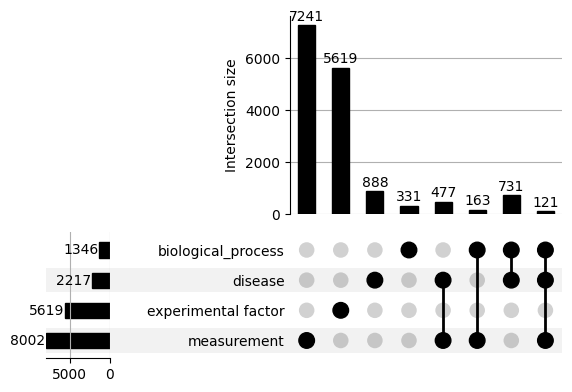

In [34]:
#check overlap for only traits in the GWAS catalog
table=from_contents(par_children_cat)  
UpSet(table, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset.pdf')

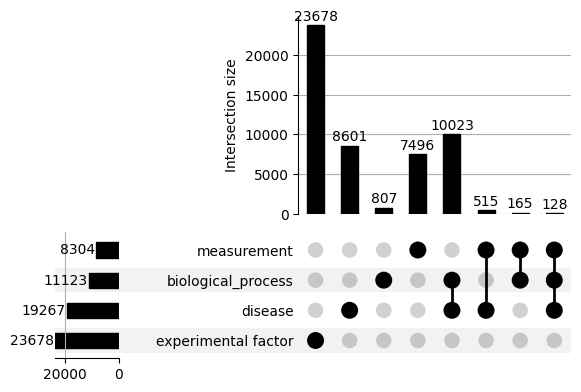

In [35]:
#check for all traits
table=from_contents(par_children)  
UpSet(table, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset.pdf')

## calculate number of genes per trait

In [34]:
gpt_path='validation_datasets/GWAS-CAT-EFO_genes_per_trait.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait([name_to_id[x] for x in par],cat,'GENE','EFO_term',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# choose datasets for analysis- put gene lists into dictionary

In [43]:
coloc_dict.keys()

dict_keys(['seed_r', 'seed_h', 'seed_hr', 'net', 'graph', 'magma_hm_ref', 'magma_rat_ref', 'hm_net', 'rat_net', 'magma_hm_rat_overlap_ref'])

In [44]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

#choose which community to check enrichment for
#must be keys from coloc_dict
sub_community='hm_net'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [45]:
filter_traits=False
gpt=genes_per_trait[(genes_per_trait.ngenes>=5)]

In [46]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [47]:
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
if sub_community in val_lab_dict.keys():
    whole_community=coloc_dict_ref[sub_community]
    outpath=f'validation_output/GWAS-CAT-EFO_enr_{val_lab_dict[sub_community]}_enr.csv'

else:
    print('sub_community not in val_lab_dict- using graph as the whole_community')
    whole_community='graph'
    outpath='validation_output/GWAS-CAT-EFO_enr_temp.csv'
print(f'path for this output file: {outpath}')
if (outpath=='validation_output/GWAS-CAT-EFO_enr_temp.csv'):
    print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
elif (os.path.isfile(outpath)):
    run_analysis=False
    print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
    tbl=pd.read_csv(outpath)
else:
    run_analysis=True
    print('this analysis has not been run- run_analysis set to True')

path for this output file: validation_output/GWAS-CAT-EFO_enr_network-ext_top500-loco_gsem_FDR_human_specific_PCNet2.0_enr.csv
this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True


# validate whole geneset at all depths of the GWAS catalog

In [48]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(cat['GENE'].dropna()))

In [49]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')

	THIS IS CALCULATED FROM loco_gsem_FDR, ext_top500, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)


In [ ]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'exploratory factor',cat,'EFO_term','GENE',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=5,verbose=True,enr_concat=None)
    #tbl.to_csv(outpath,index=False)
    #print(f'table saved as {outpath}')

analyzing structure depth=0
Enrichment of network nodes in genes in the GWAS catalog annotated for disease: p=0.01125323500828774
Enrichment calculated using hypergeom.sf for disease: p=0.01125323500828774, p_contingency_table=0.02429515863134281
Odds ratio: OD=1.574344093299443, via_contingency OR=1.574344093299443
Number of annotated genes in graph: 15766
Number of annotated genes in hm_net: 335

Number of genes in interactome annotated for trait: 362
Enrichment of network nodes in genes in the GWAS catalog annotated for measurement: p=0.16327787937623145
Enrichment calculated using hypergeom.sf for measurement: p=0.16327787937623145, p_contingency_table=0.27124552704538774
Odds ratio: OD=1.3677811974076932, via_contingency OR=1.3677811974076932
Number of annotated genes in graph: 16895
Number of annotated genes in hm_net: 349

Number of genes in interactome annotated for trait: 362
Enrichment of network nodes in genes in the GWAS catalog annotated for biological_process: p=5.8766669

In [49]:
if ('net' in sub_community):
    if not 'n_seed' in tbl.columns:
        if 'community_genes' in tbl.columns:
            col='community_genes'
        else:
            col='network_genes'
        if type(tbl[col].iloc[0])!=set:
            tbl['seed_h']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
        else:
            tbl['seed_h']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_r']))
        tbl['n_seed_h']=tbl.seed_h.apply(lambda x: len(x))
        tbl['n_seed_r']=tbl.seed_r.apply(lambda x: len(x))
        tbl['n_seed']=tbl['n_seed_h']+tbl['n_seed_r']
        if not filter_traits:
            tbl.to_csv(outpath,index=False)
        tbl.sort_values('n_seed',ascending=False).head()

In [50]:
#filter_traits=True
print(f'filter traits={filter_traits}')

filter traits=False


In [51]:
if filter_traits:
    print('filtering traits')
    tbl=tbl[tbl.trait.isin(gpt.trait_name)]
tbl[tbl.p_intersect<0.05/len(tbl)].sort_values('n_seed')

trait  \
1155                  smoking cessation   
80                    smoking cessation   
1998             loneliness measurement   
90               loneliness measurement   
122              loneliness measurement   
629              loneliness measurement   
325                mathematical ability   
1142               mathematical ability   
1151                 smoking initiation   
76                   smoking initiation   
49       cognitive function measurement   
321      cognitive function measurement   
981      cognitive function measurement   
1138     cognitive function measurement   
240                   neurotic disorder   
328                        intelligence   
1145                       intelligence   
723             neuroticism measurement   
100             neuroticism measurement   
714             neuroticism measurement   
132             neuroticism measurement   
2008                   anxiety disorder   
1109            neuroticism measurement   
634             neuroticism measurement   
2003            neuroticism measurement   
639                    anxiety disorder   
761          substance-related disorder   
1793         substance-related disorder   
998       personality trait measurement   
55                     diet measurement   
987                    diet measurement   
66        personality trait measurement   
1540      personality trait measurement   
1177                  personality trait   
395                      mental process   
875                           cognition   
199                           cognition   
177                      mental process   
429                            behavior   
401                            behavior   
63    Abnormality of the nervous system   
170    multicellular organismal process   
388    multicellular organismal process   

                                  parent_trait  \
1155                                  behavior   
80                                    behavior   
1998            mental or behavioural disorder   
90    mental or behavioural disorder biomarker   
122   mental or behavioural disorder biomarker   
629             mental or behavioural disorder   
325                                  cognition   
1142                                 cognition   
1151                                  behavior   
76                                    behavior   
49                                 measurement   
321                                  cognition   
981                                measurement   
1138                                 cognition   
240                           anxiety disorder   
328                                  cognition   
1145                                 cognition   
723              personality trait measurement   
100   mental or behavioural disorder biomarker   
714              personality trait measurement   
132   mental or behavioural disorder biomarker   
2008            mental or behavioural disorder   
1109             personality trait measurement   
634             mental or behavioural disorder   
2003            mental or behavioural disorder   
639             mental or behavioural disorder   
761                       psychiatric disorder   
1793                      psychiatric disorder   
998                                measurement   
55                                 measurement   
987                                measurement   
66                                 measurement   
1540                         personality trait   
1177                                   quality   
395                         biological_process   
875                             mental process   
199                             mental process   
177                         biological_process   
429           multicellular organismal process   
401           multicellular organismal process   
63                      Phenotypic abnormality   
170                         biological_pr

# plot enrichment

In [52]:
save_fig=True

In [53]:
if save_fig==True:
    outpath_dir=outpath[:len(outpath)-4]
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [54]:
colormap=plt.colormaps.get_cmap('tab20b')

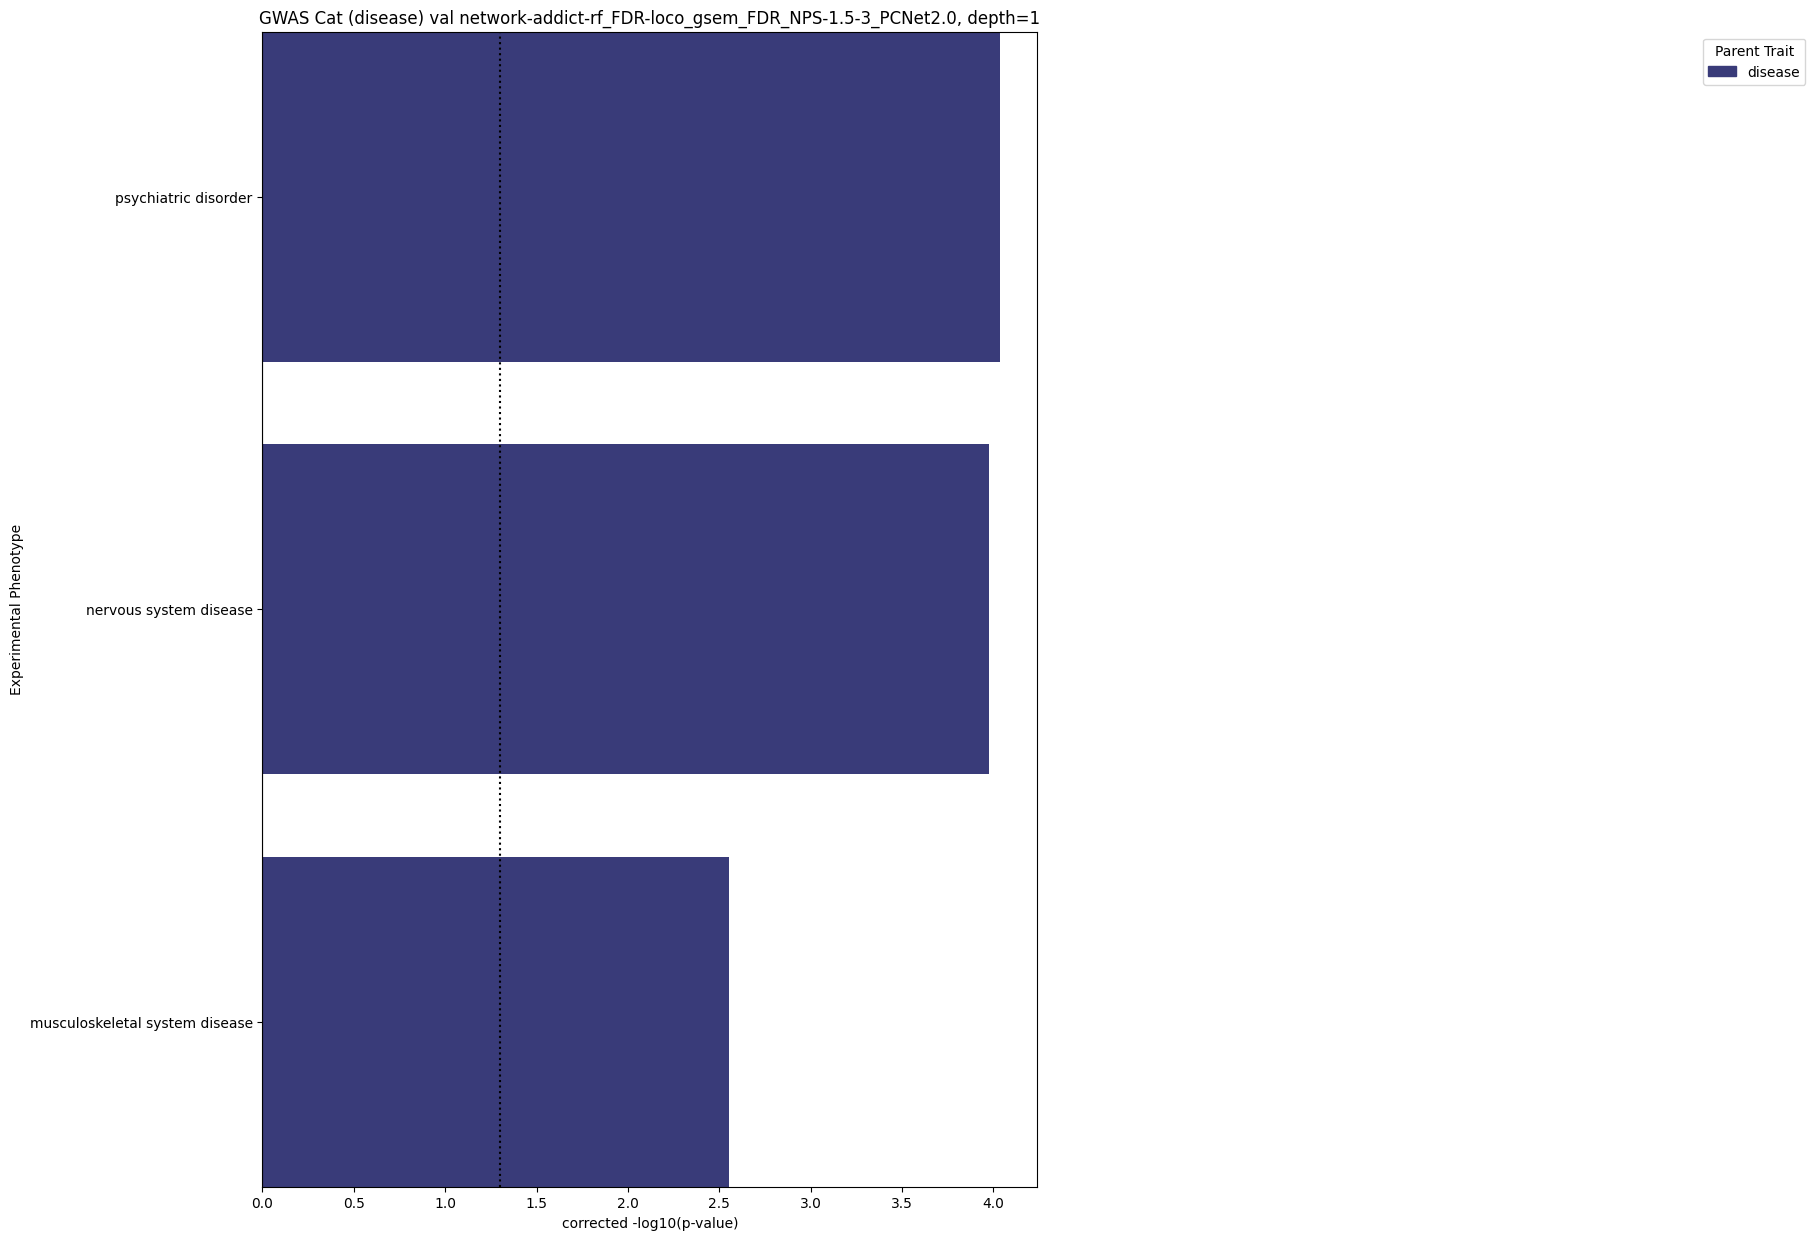

<Figure size 640x480 with 0 Axes>

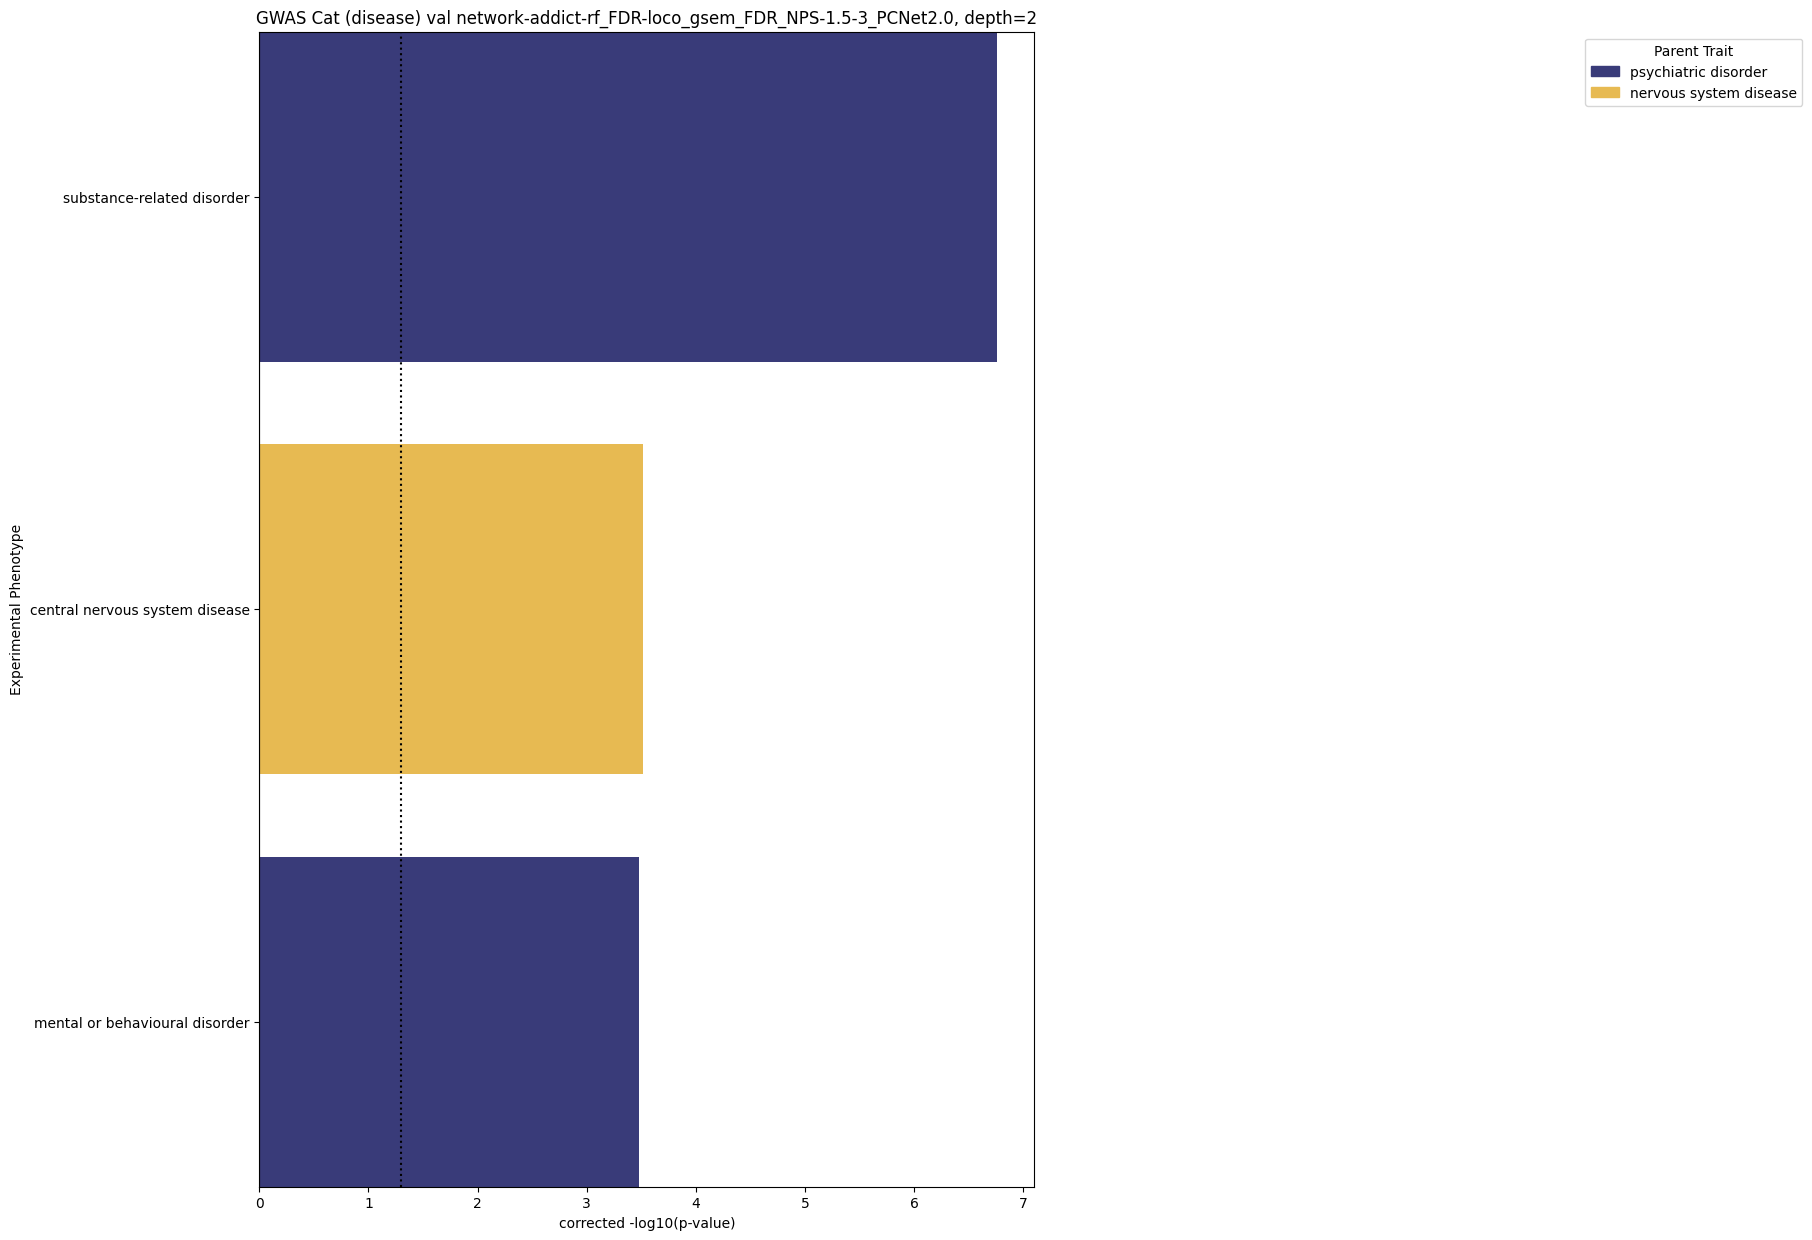

<Figure size 640x480 with 0 Axes>

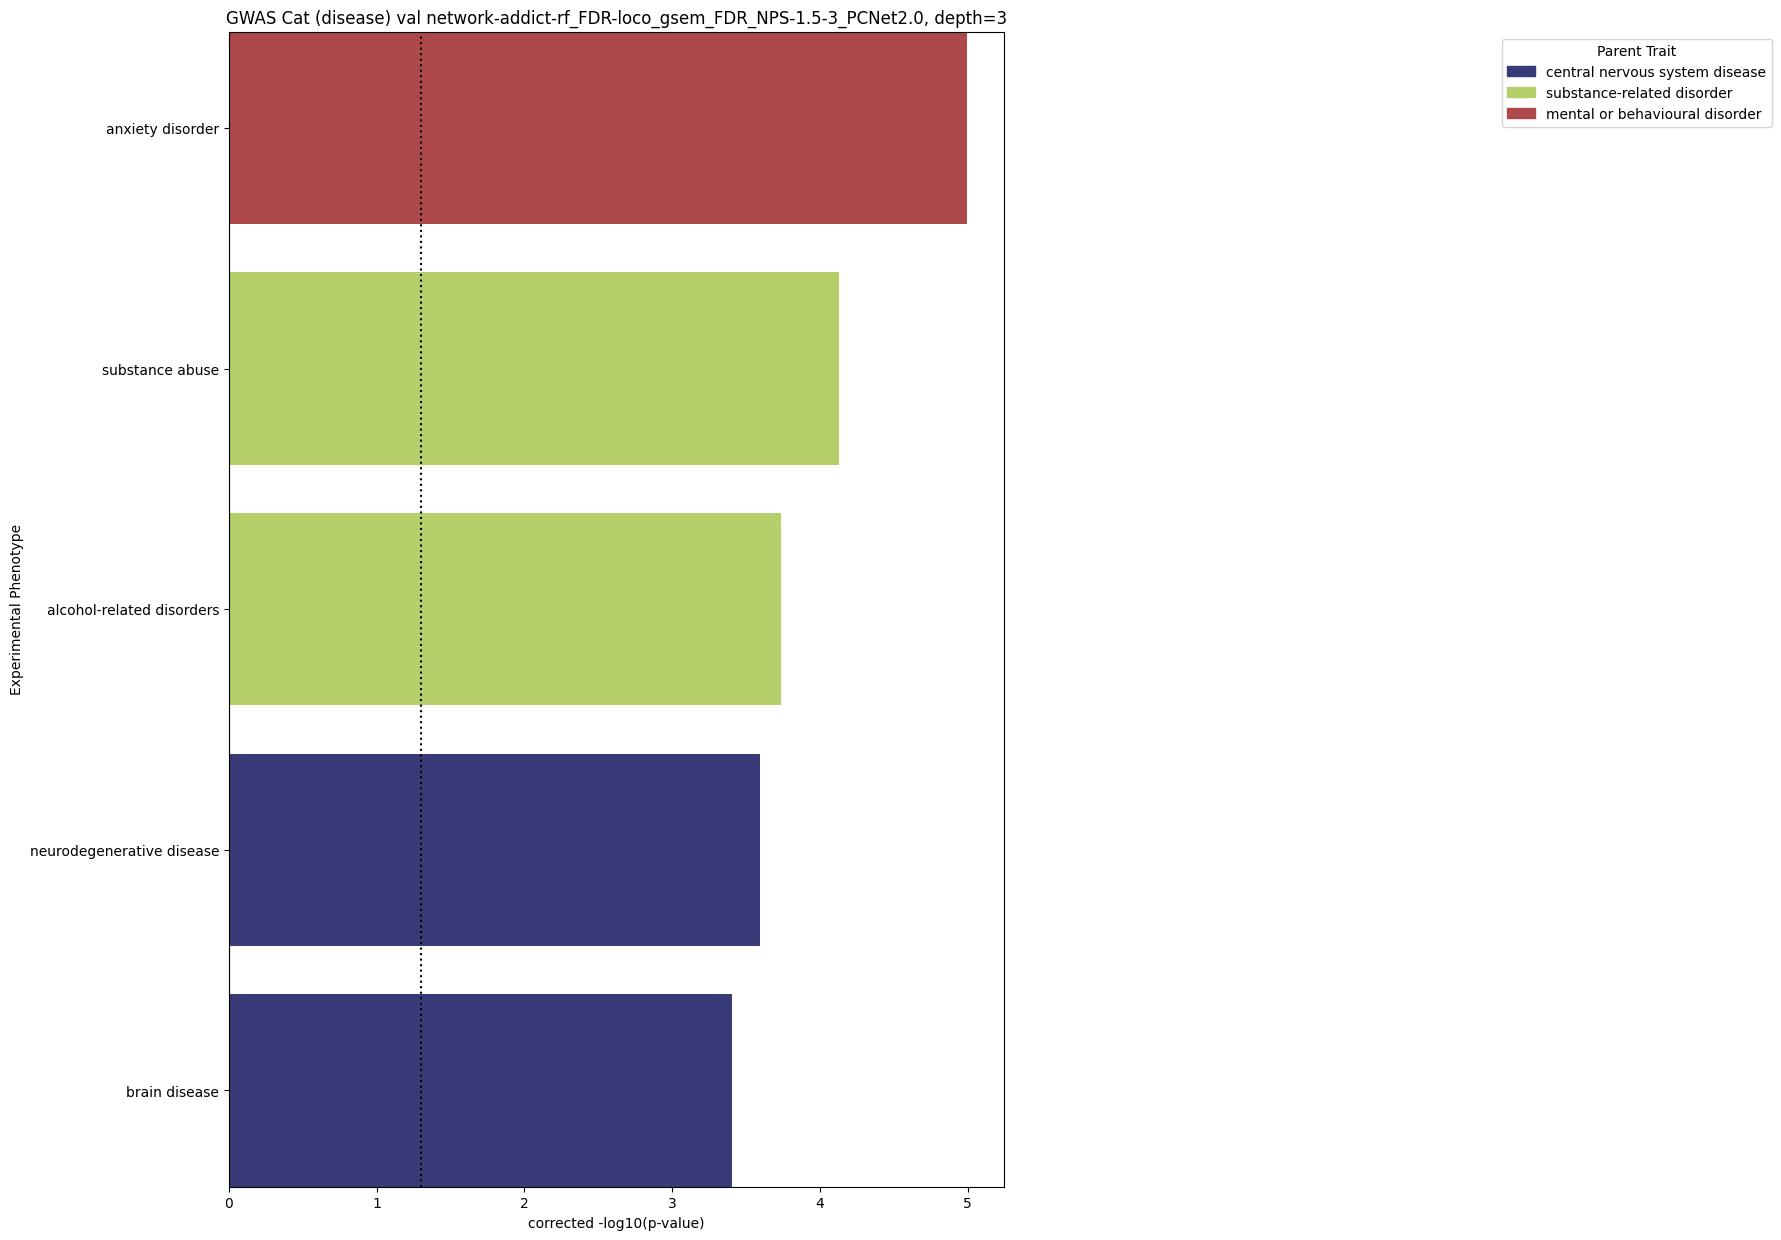

<Figure size 640x480 with 0 Axes>

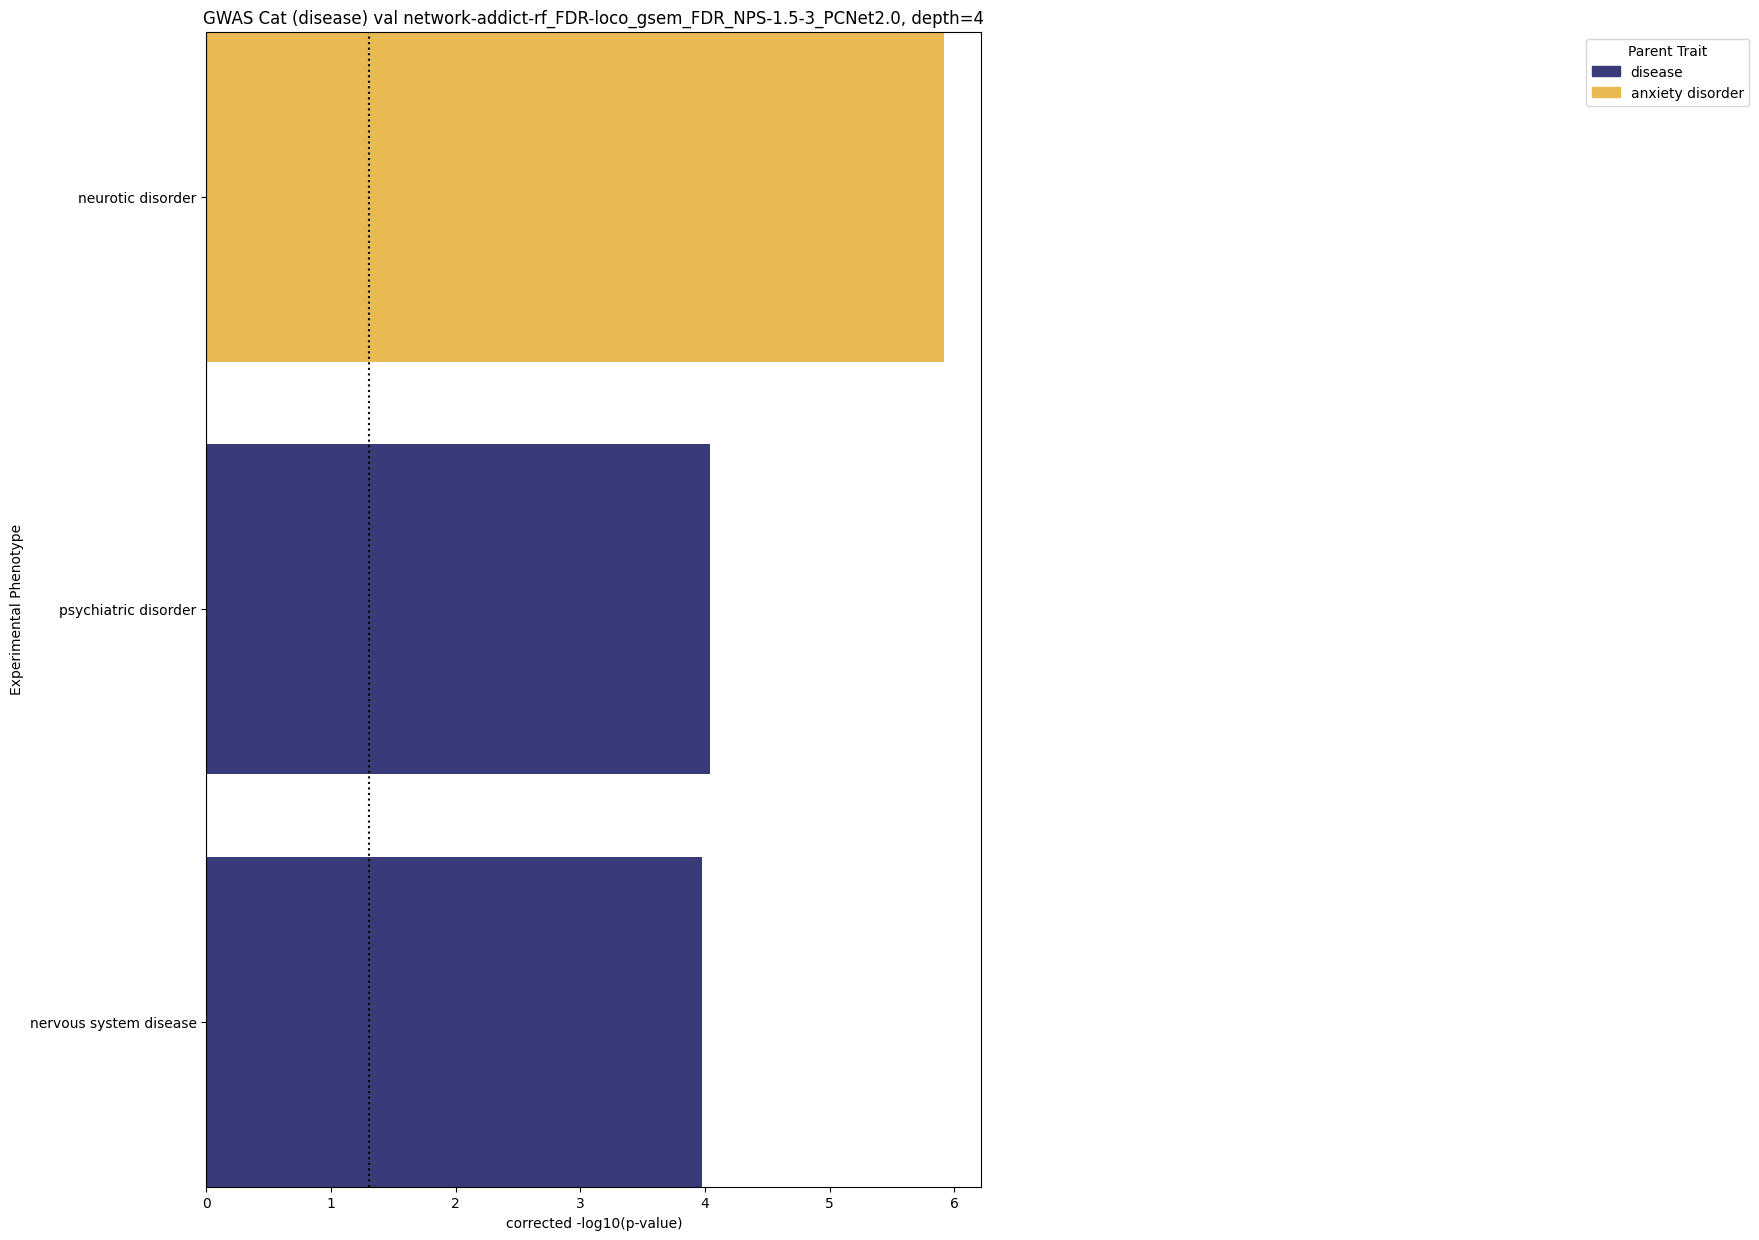

<Figure size 640x480 with 0 Axes>

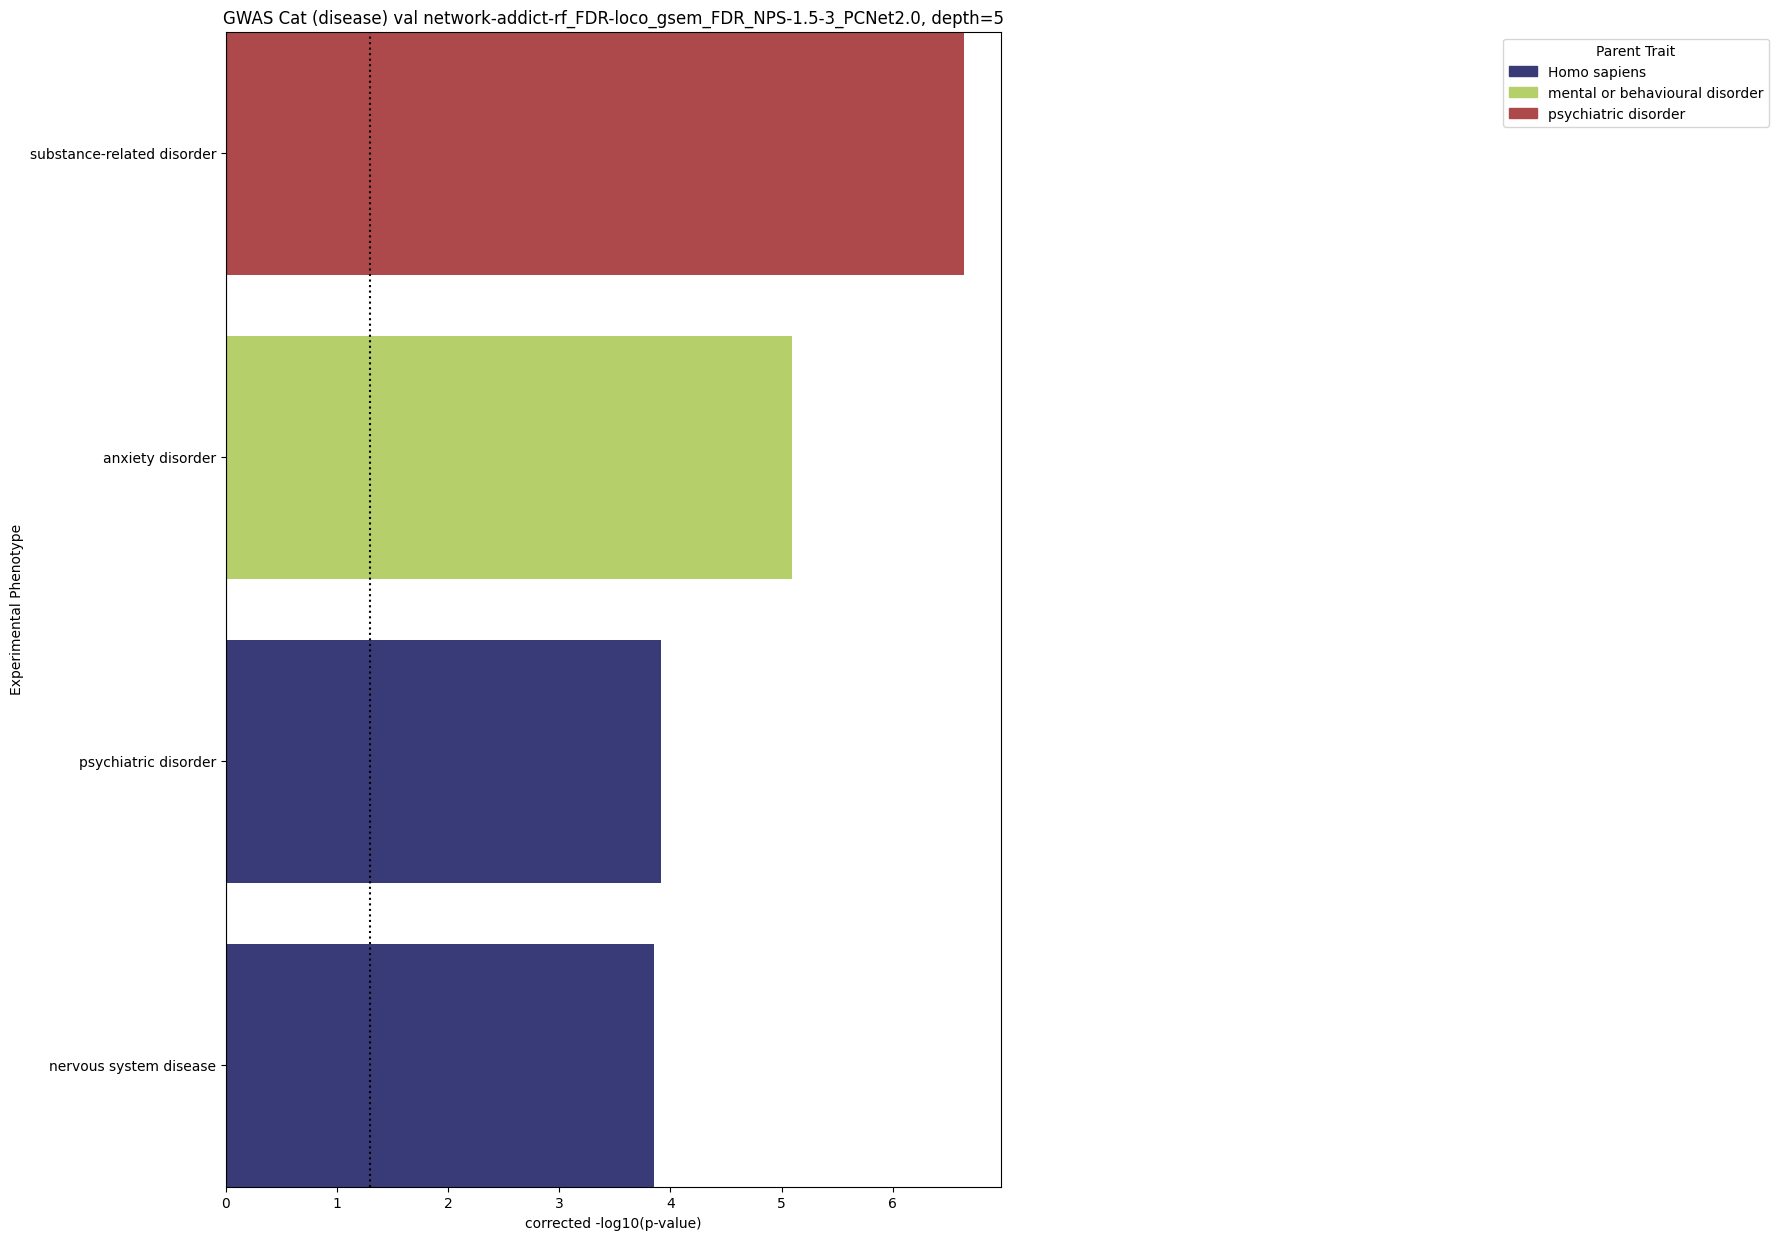

<Figure size 640x480 with 0 Axes>

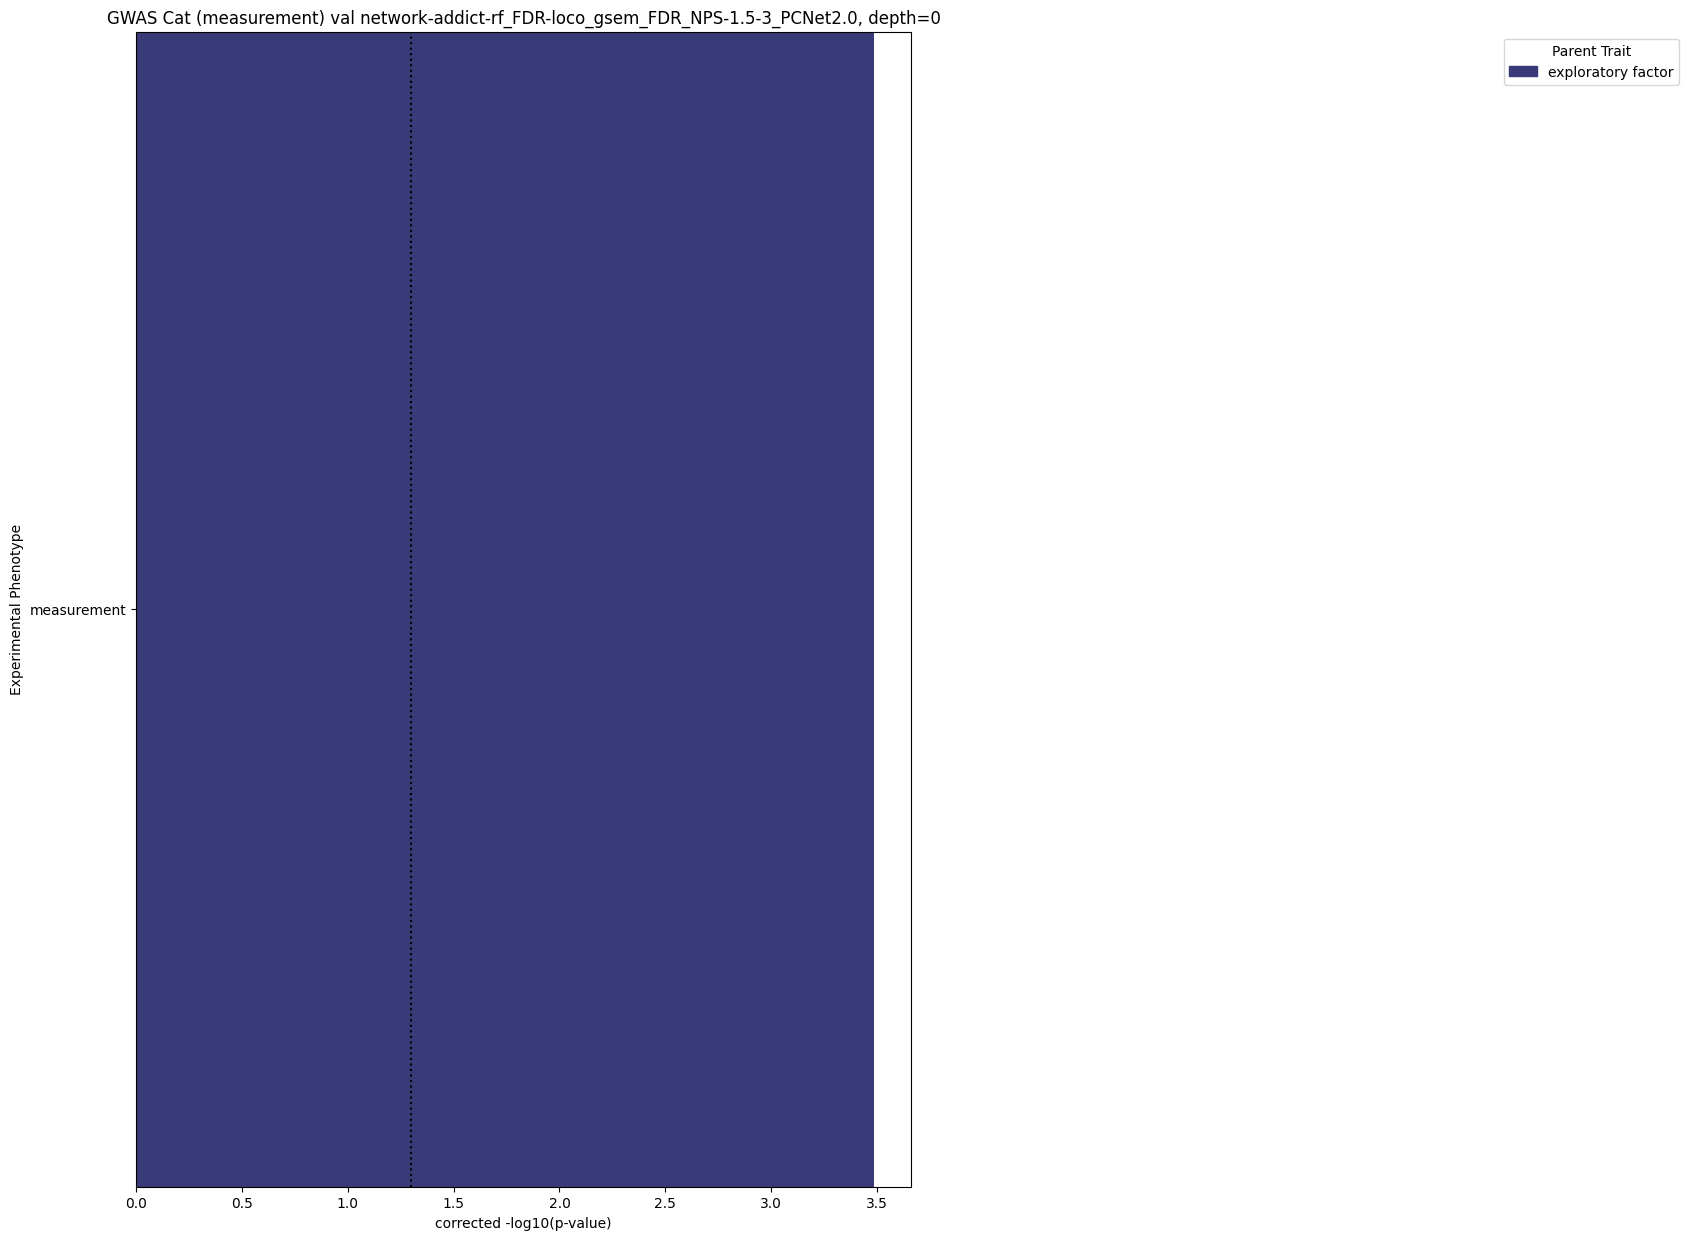

<Figure size 640x480 with 0 Axes>

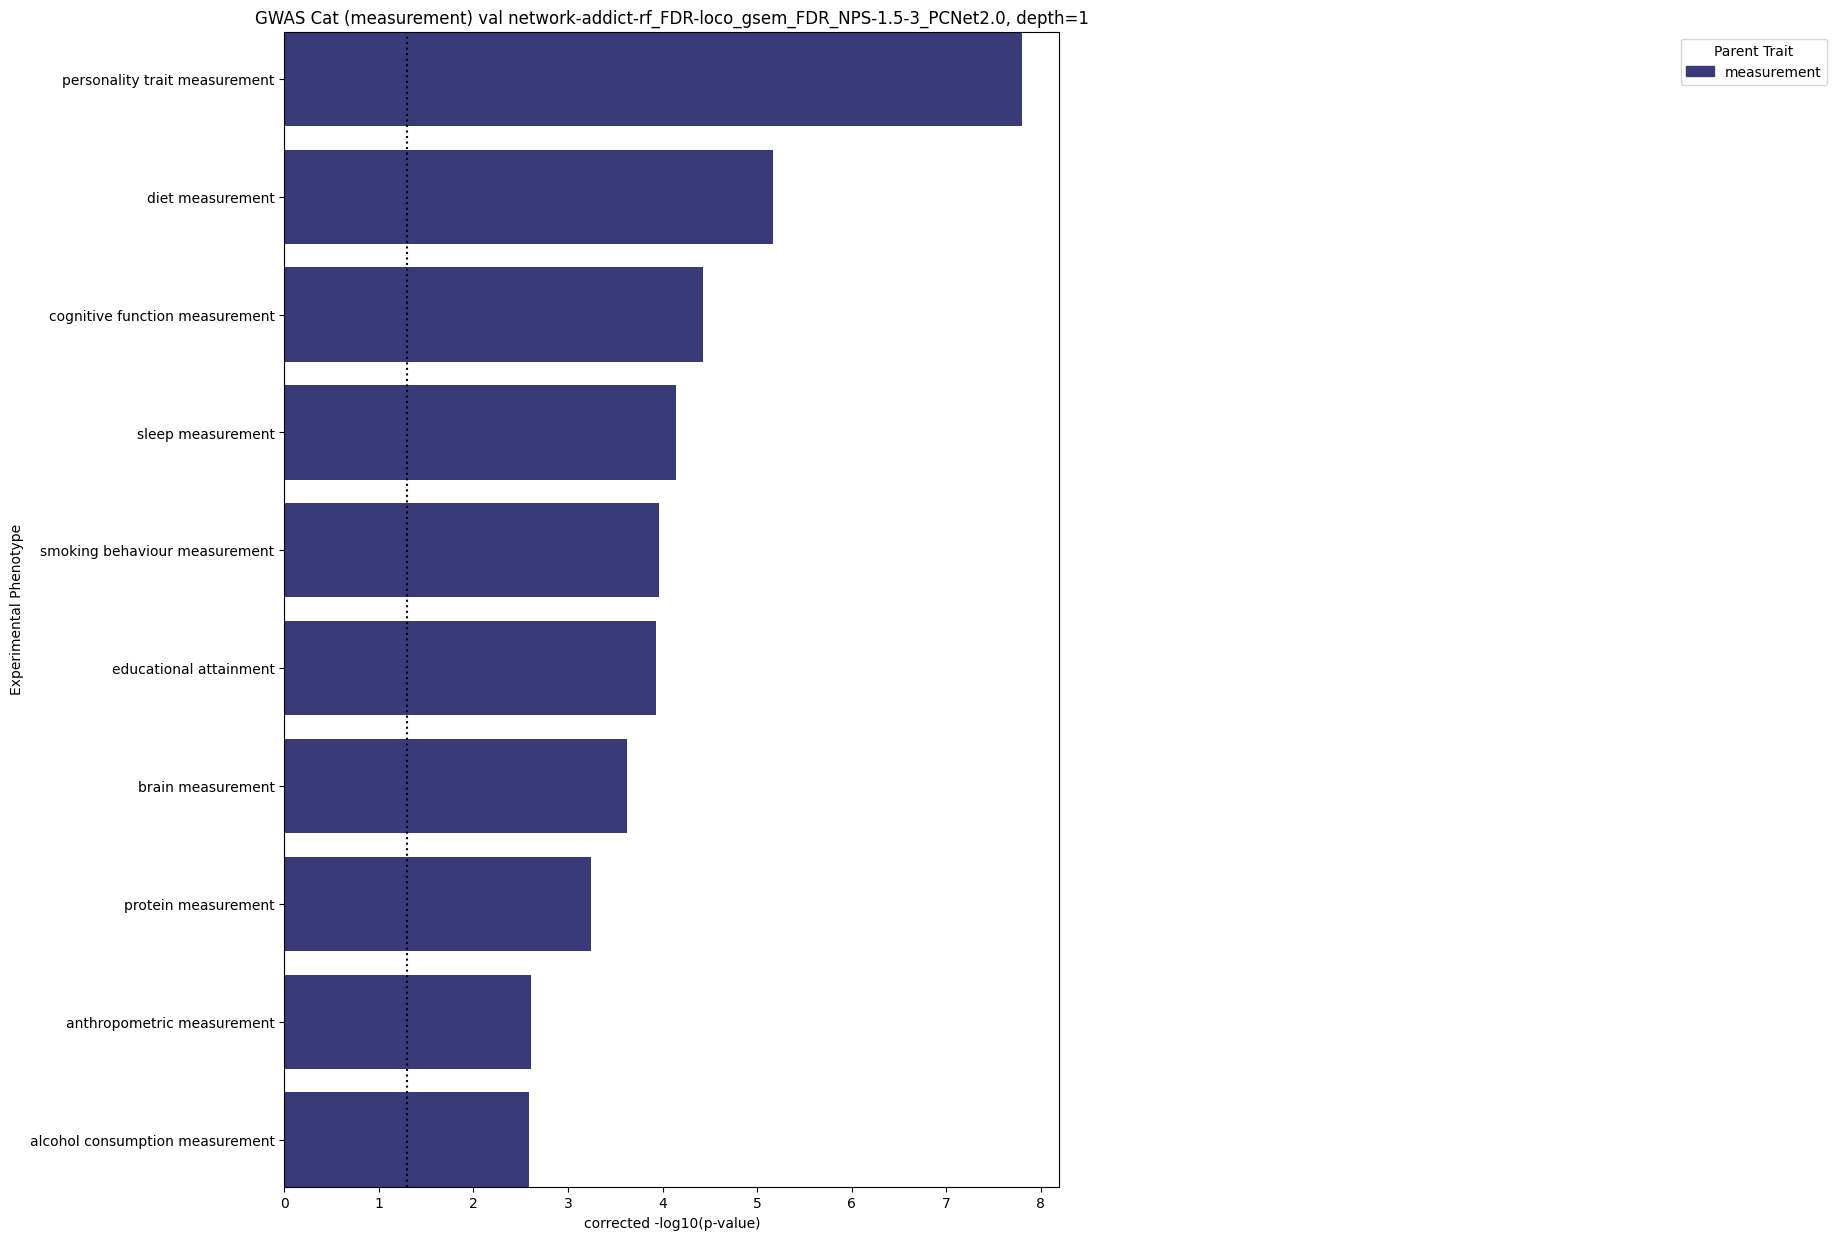

<Figure size 640x480 with 0 Axes>

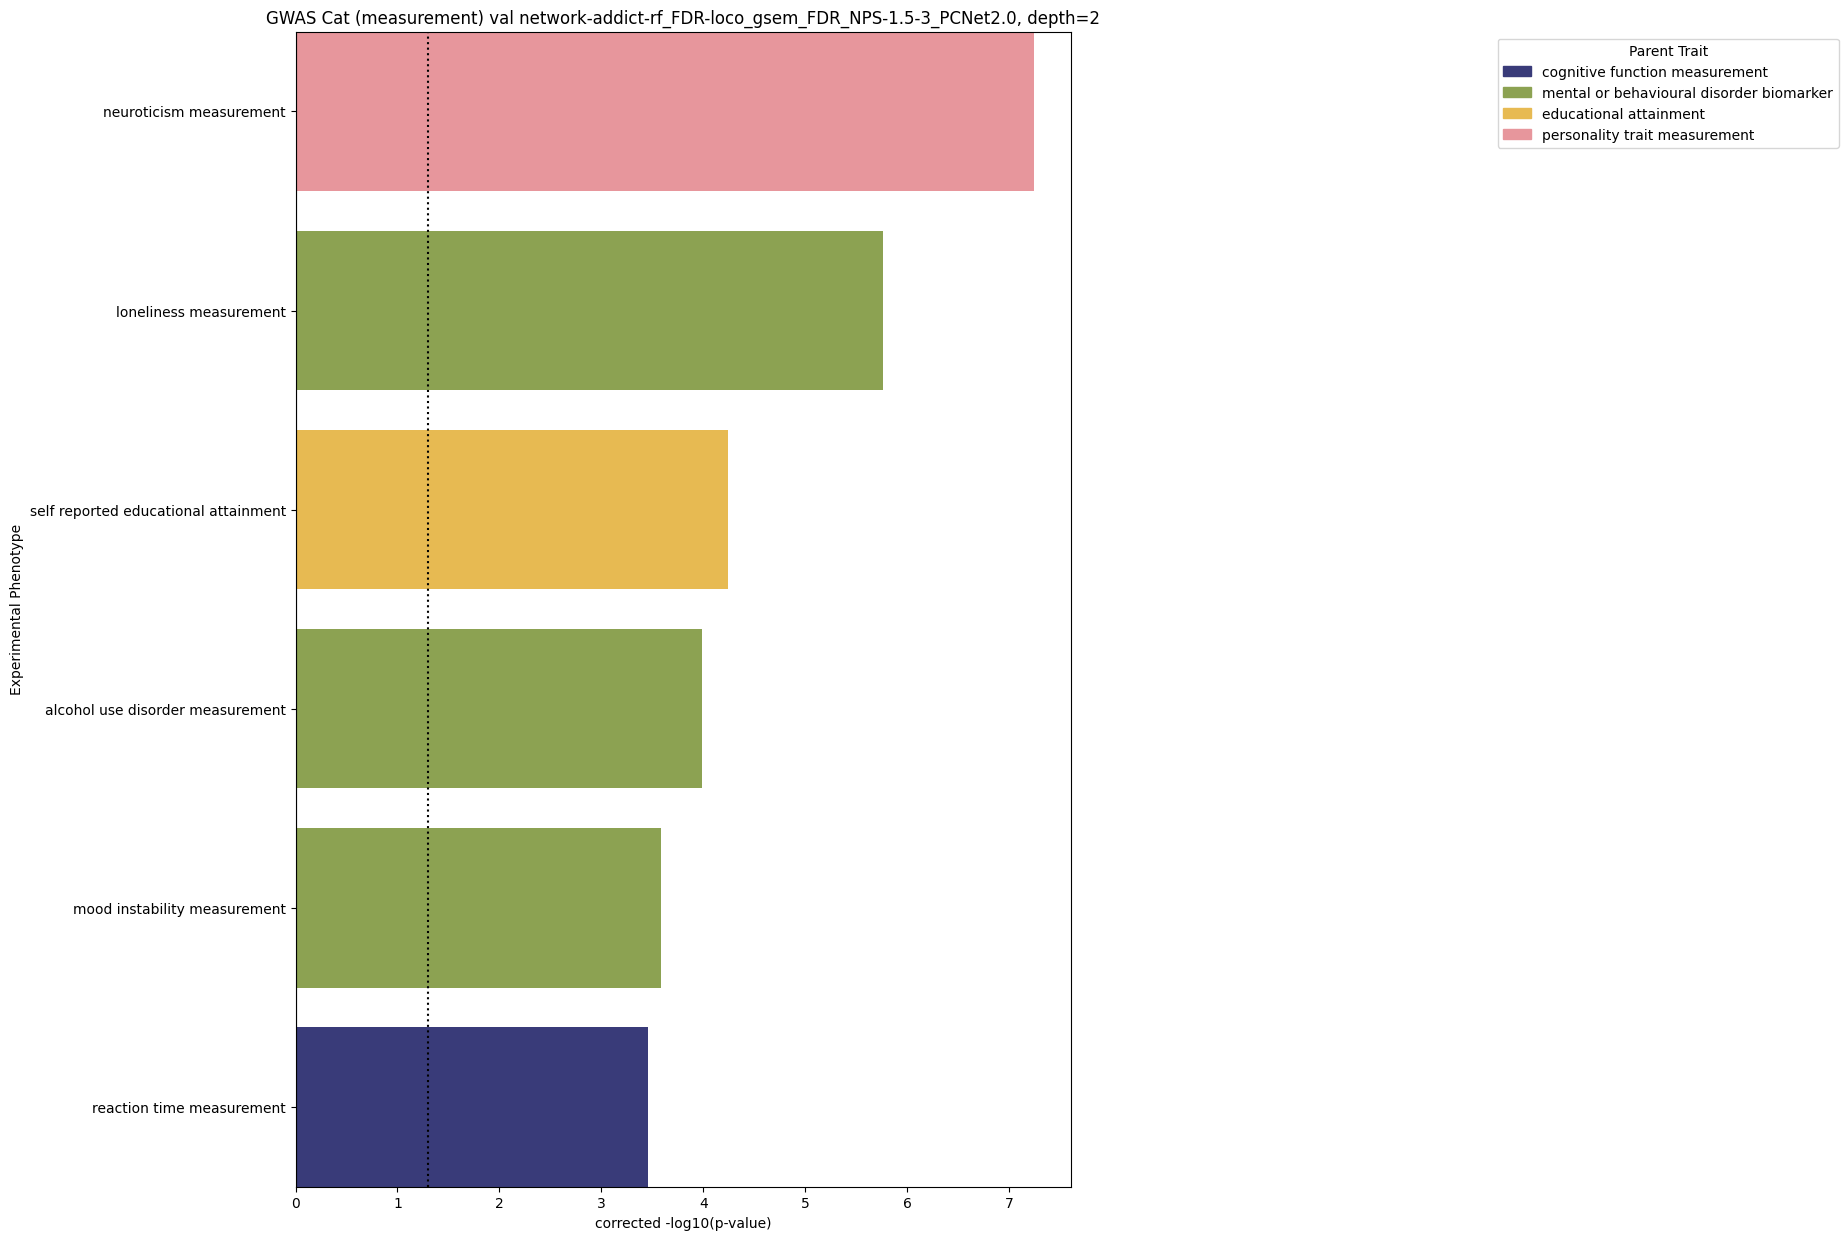

<Figure size 640x480 with 0 Axes>

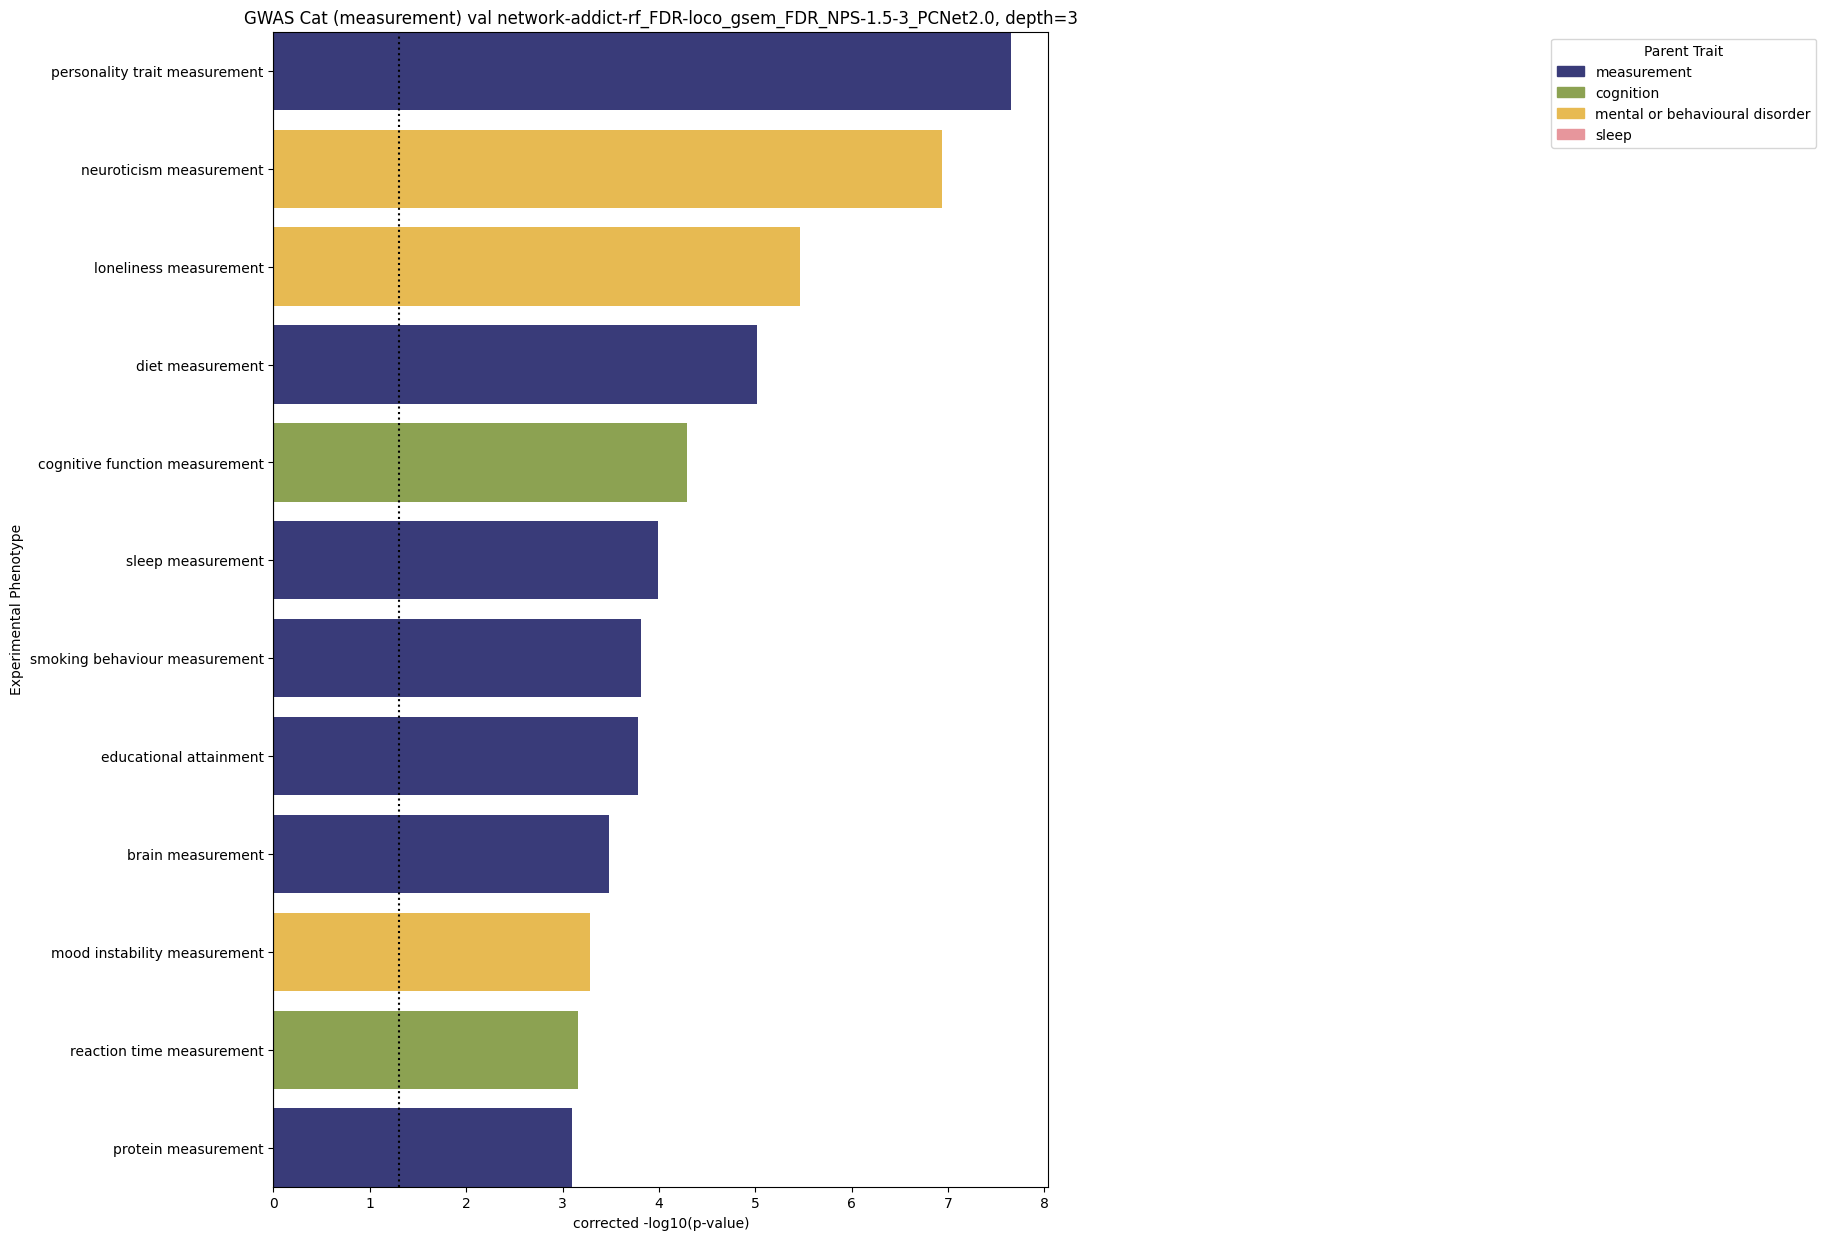

<Figure size 640x480 with 0 Axes>

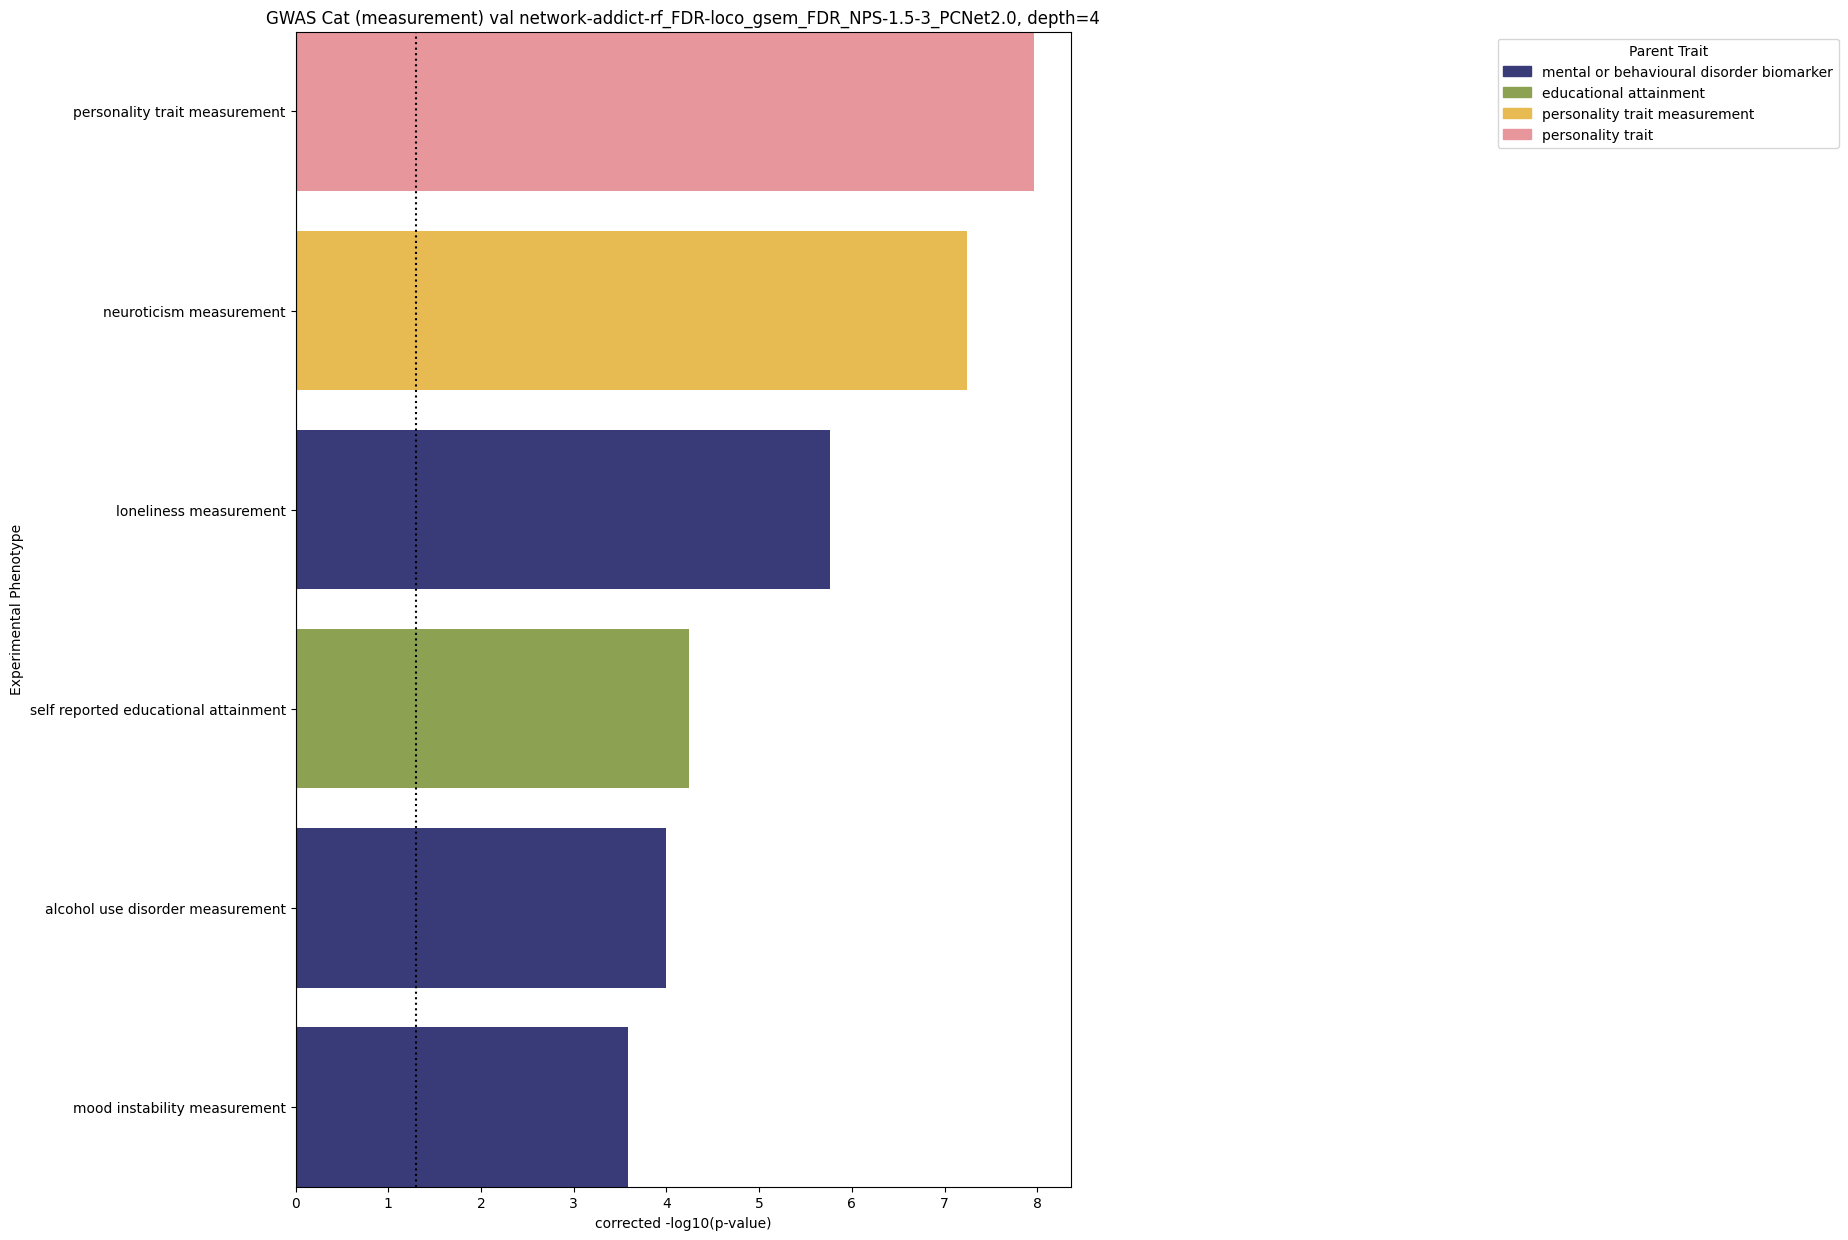

<Figure size 640x480 with 0 Axes>

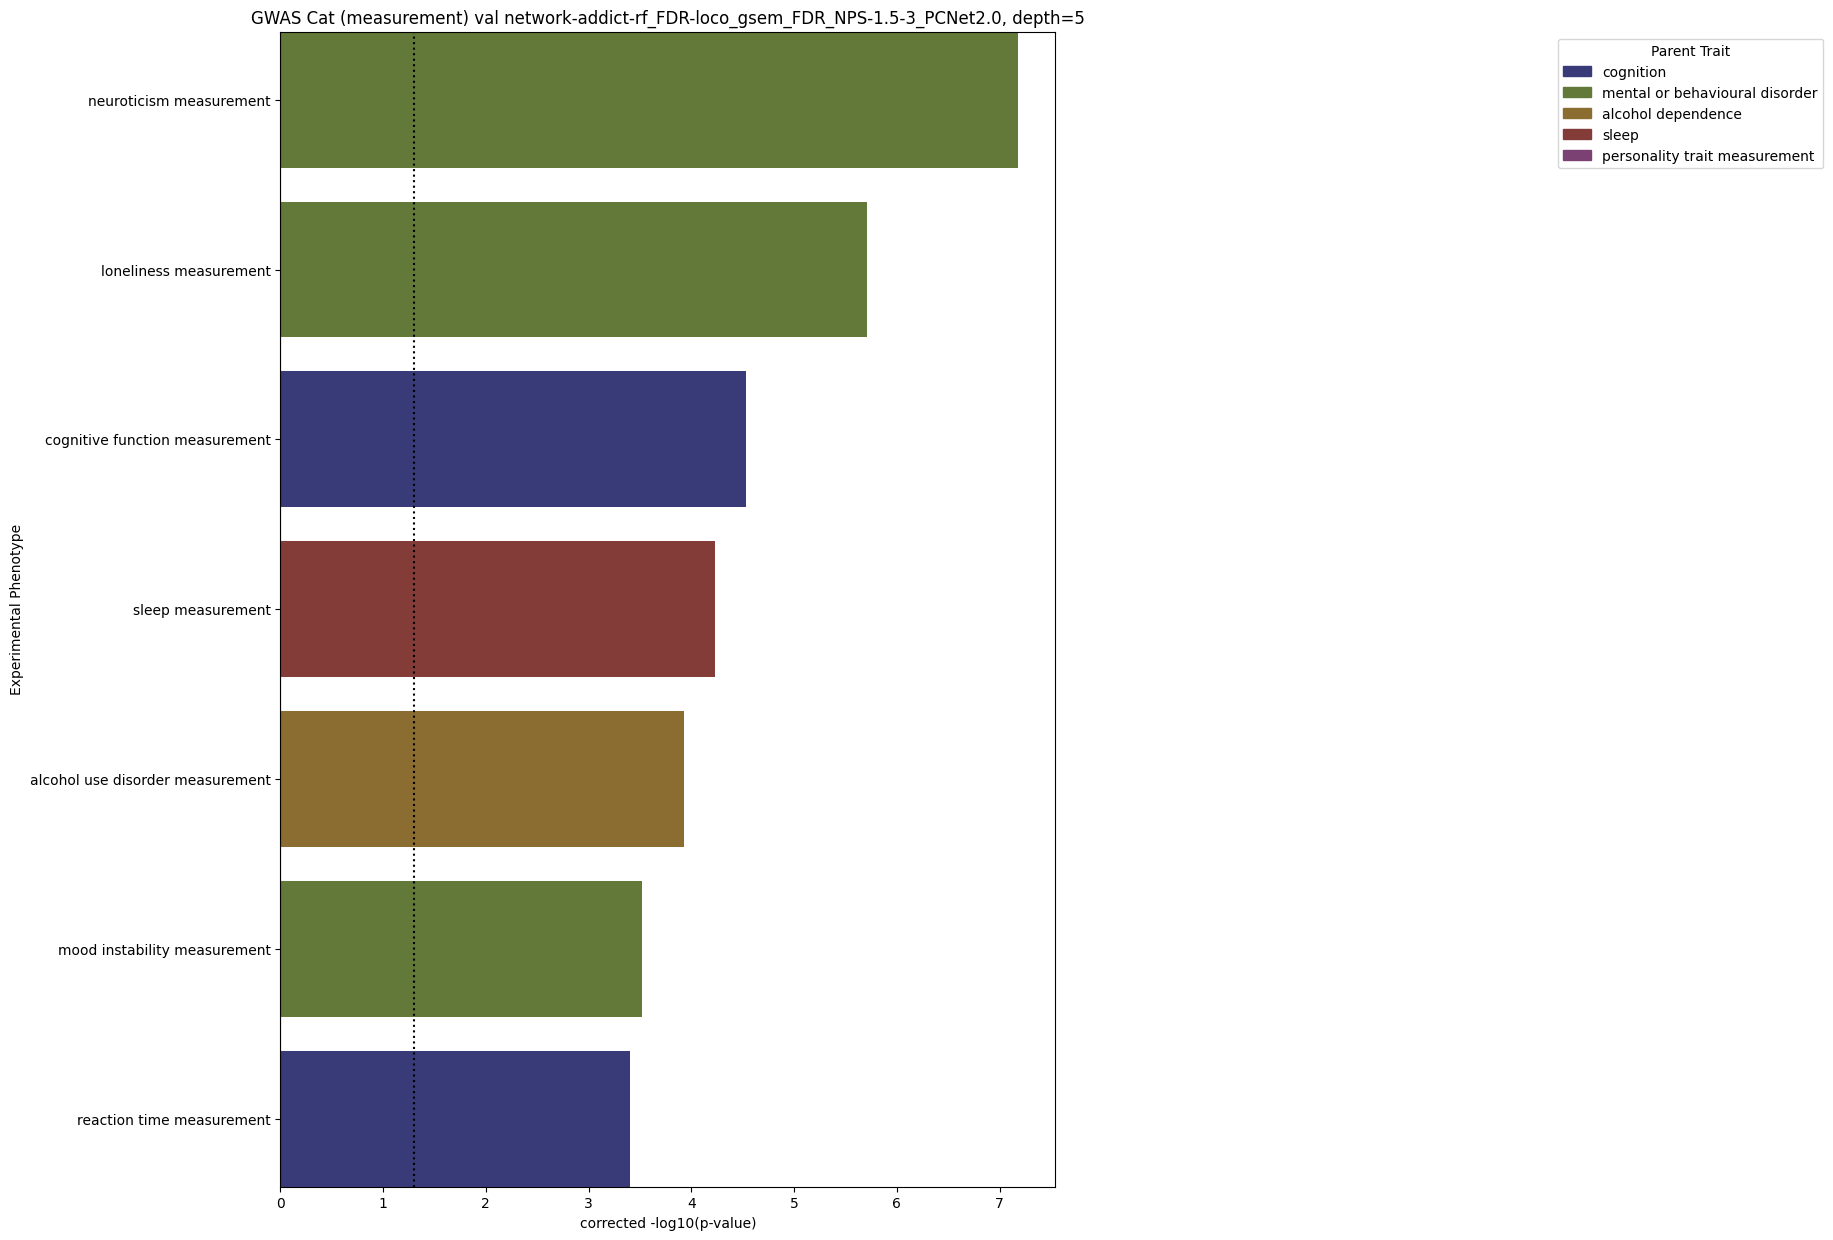

<Figure size 640x480 with 0 Axes>

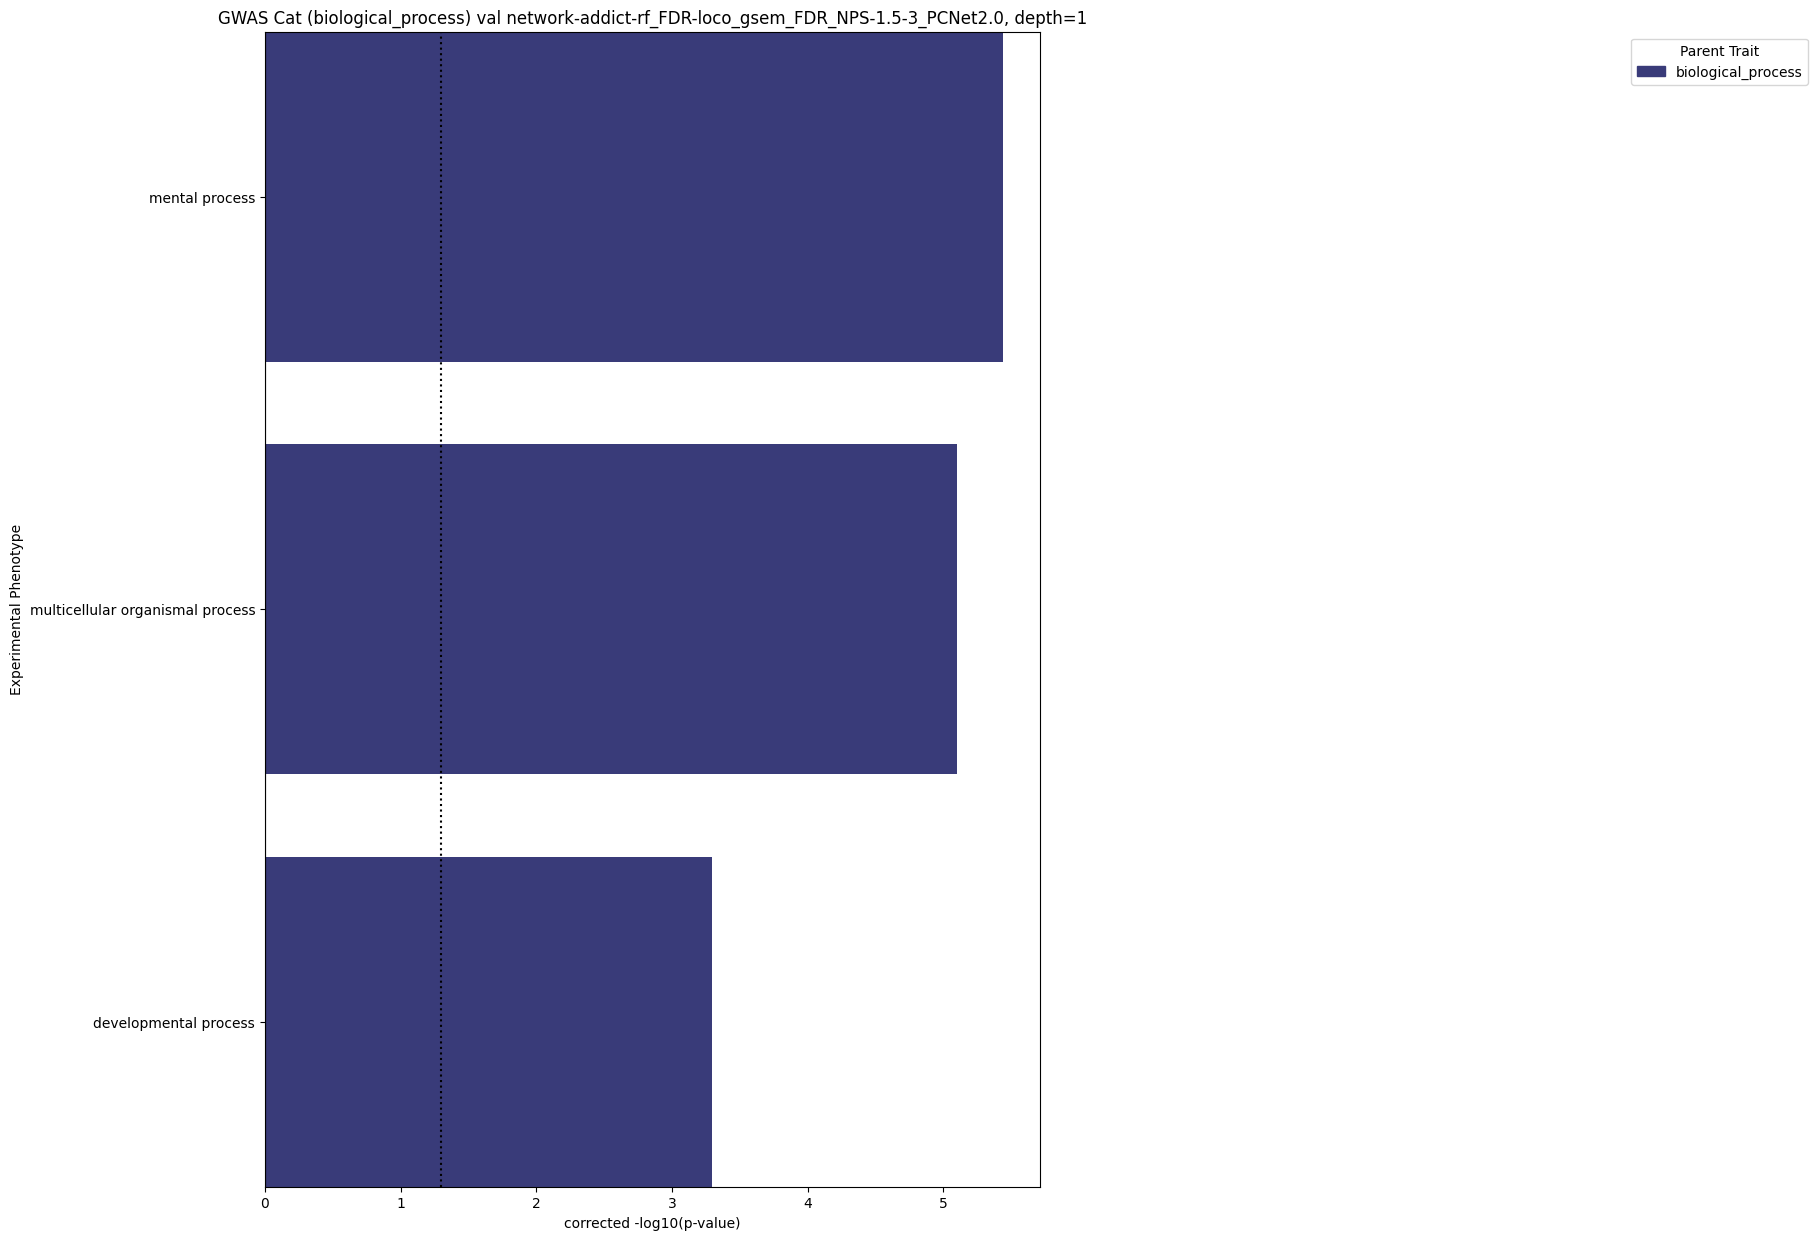

<Figure size 640x480 with 0 Axes>

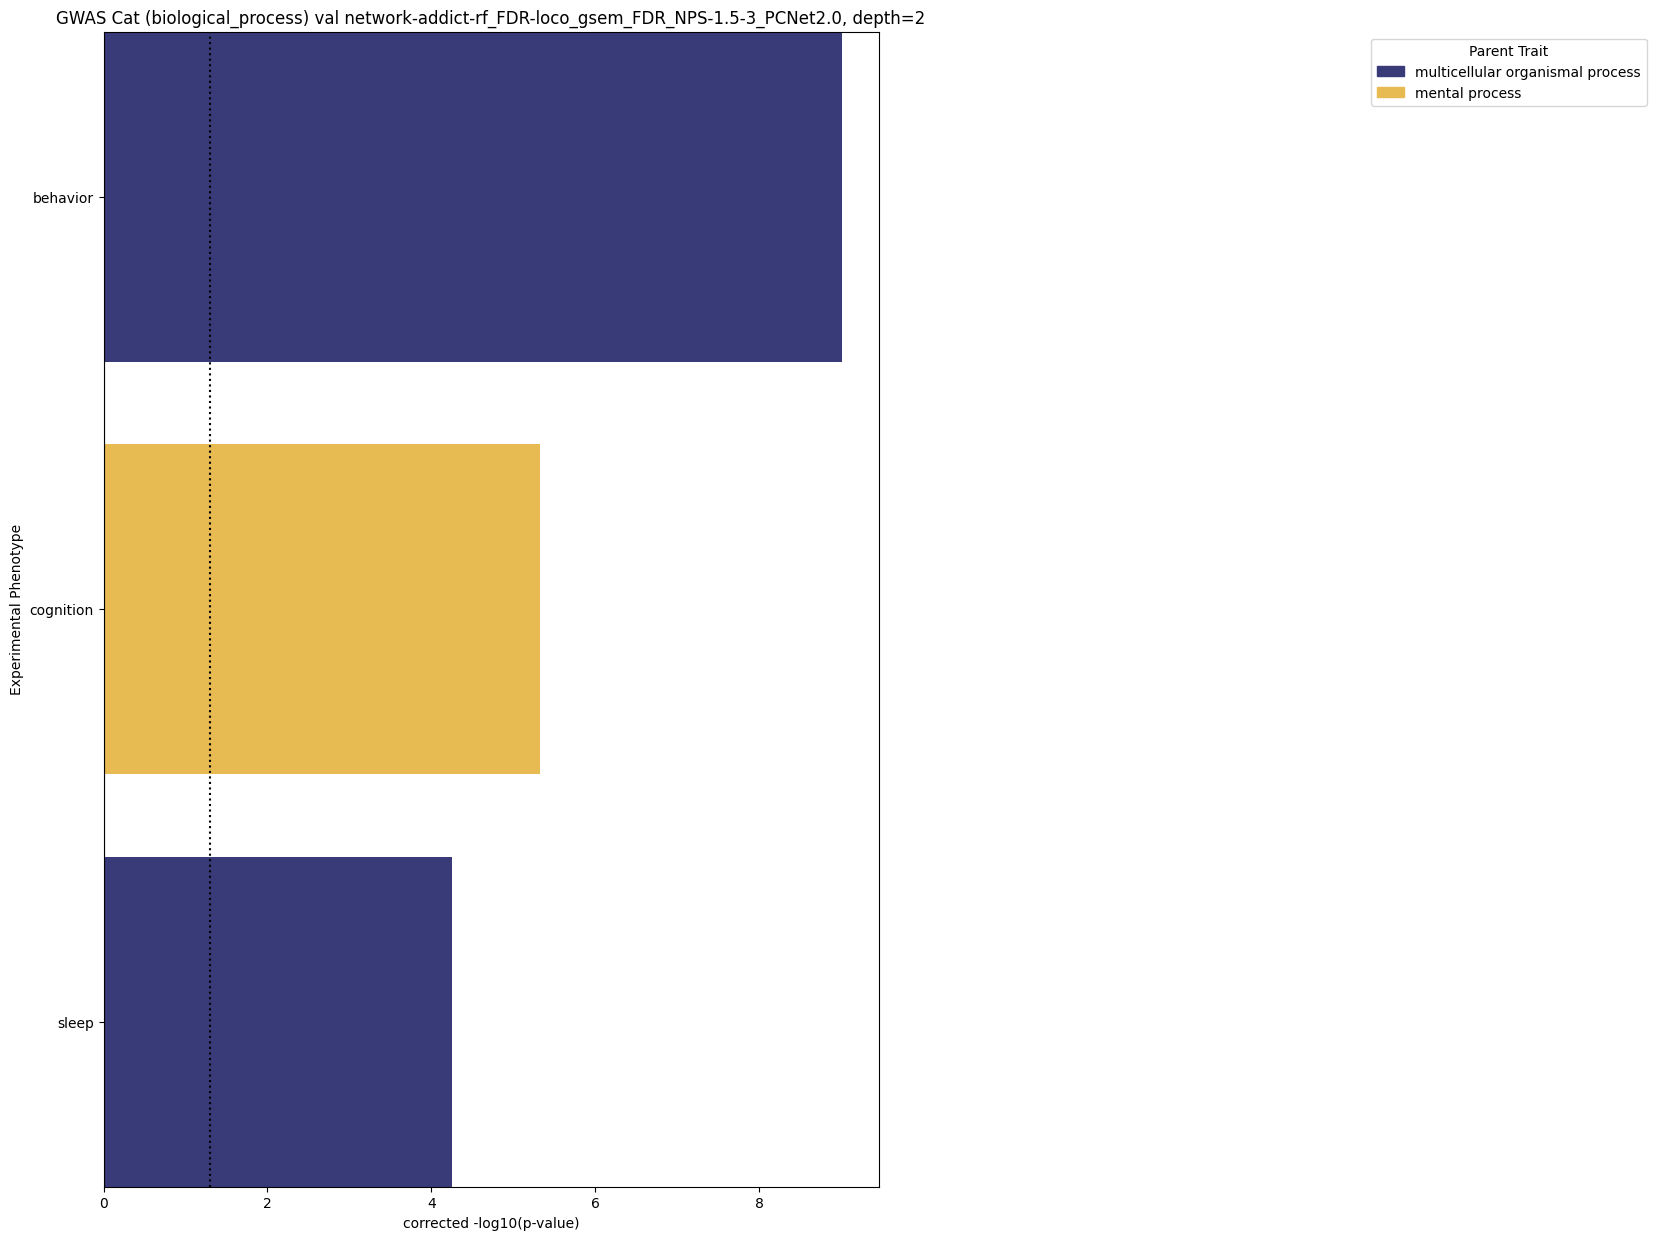

<Figure size 640x480 with 0 Axes>

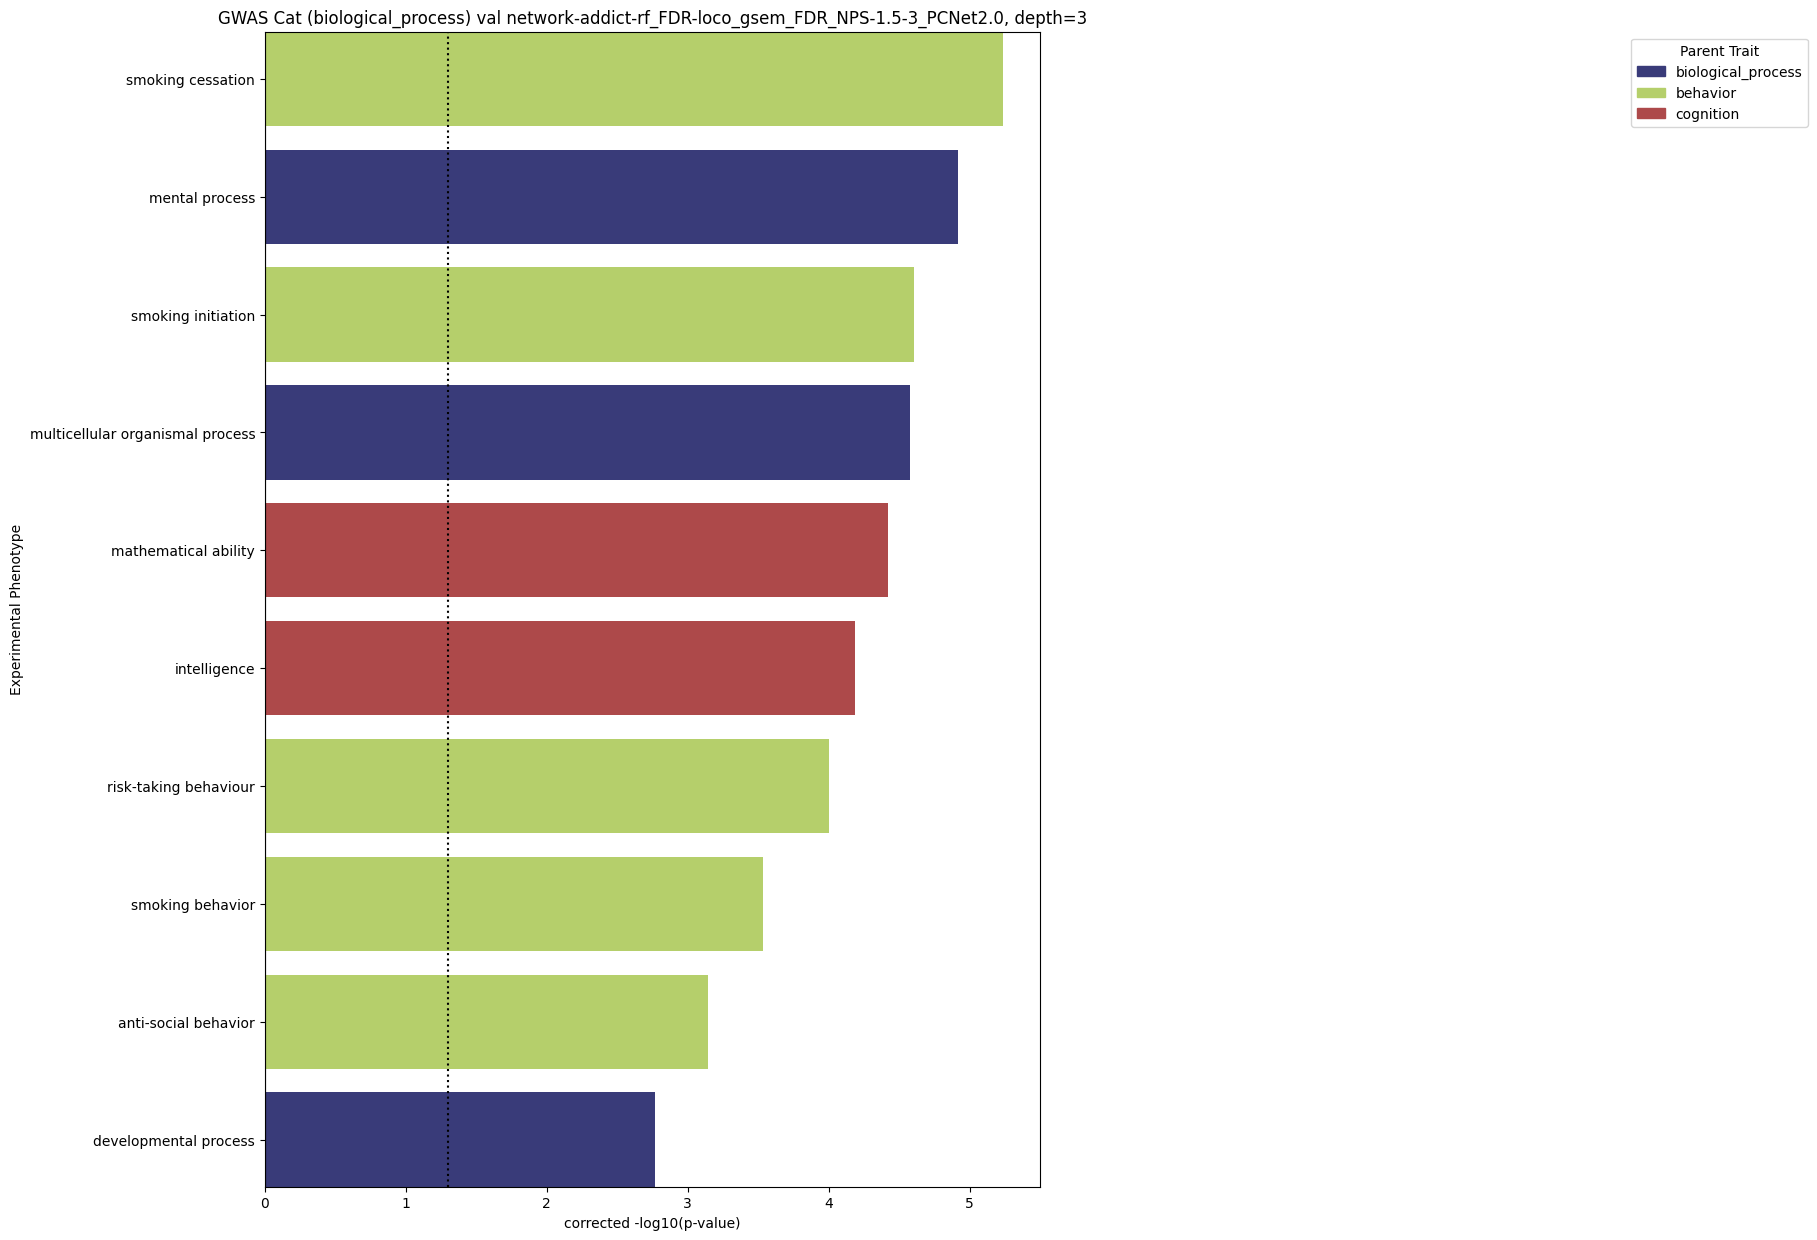

<Figure size 640x480 with 0 Axes>

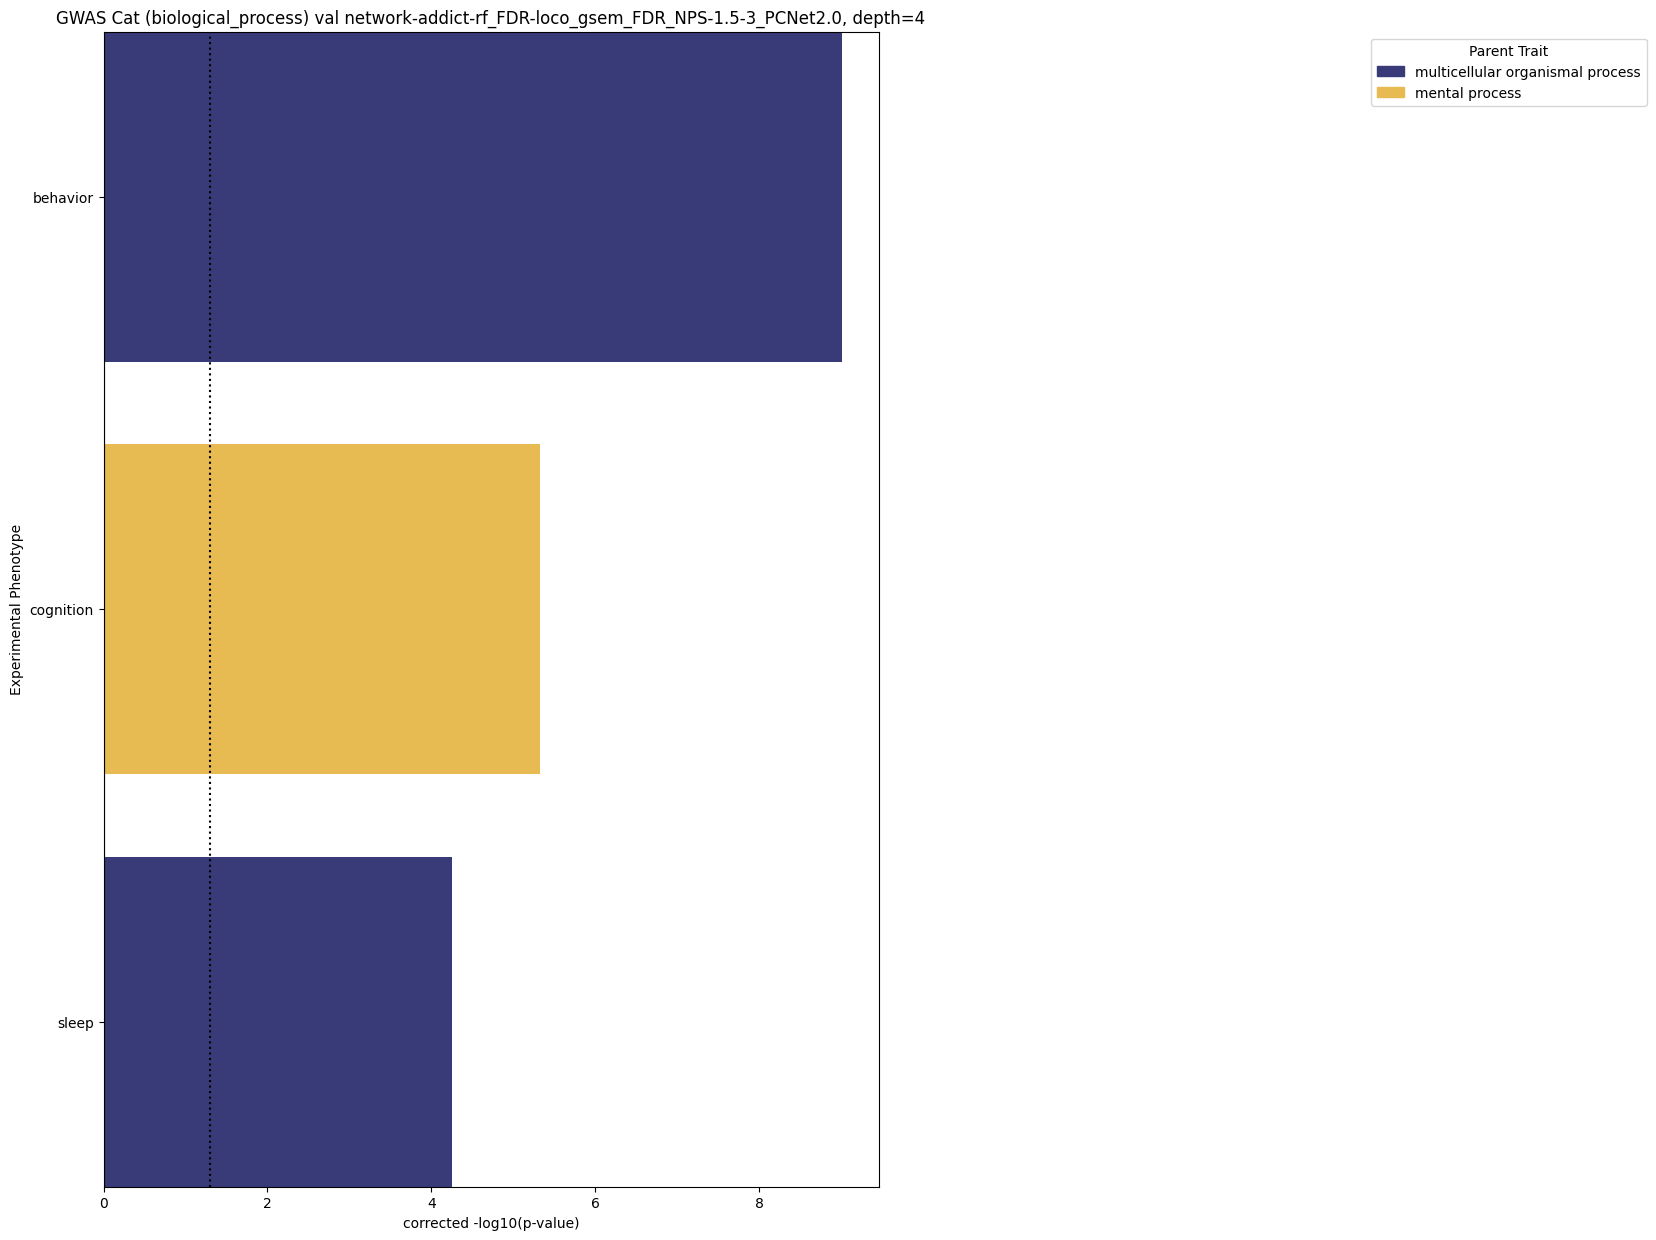

<Figure size 640x480 with 0 Axes>

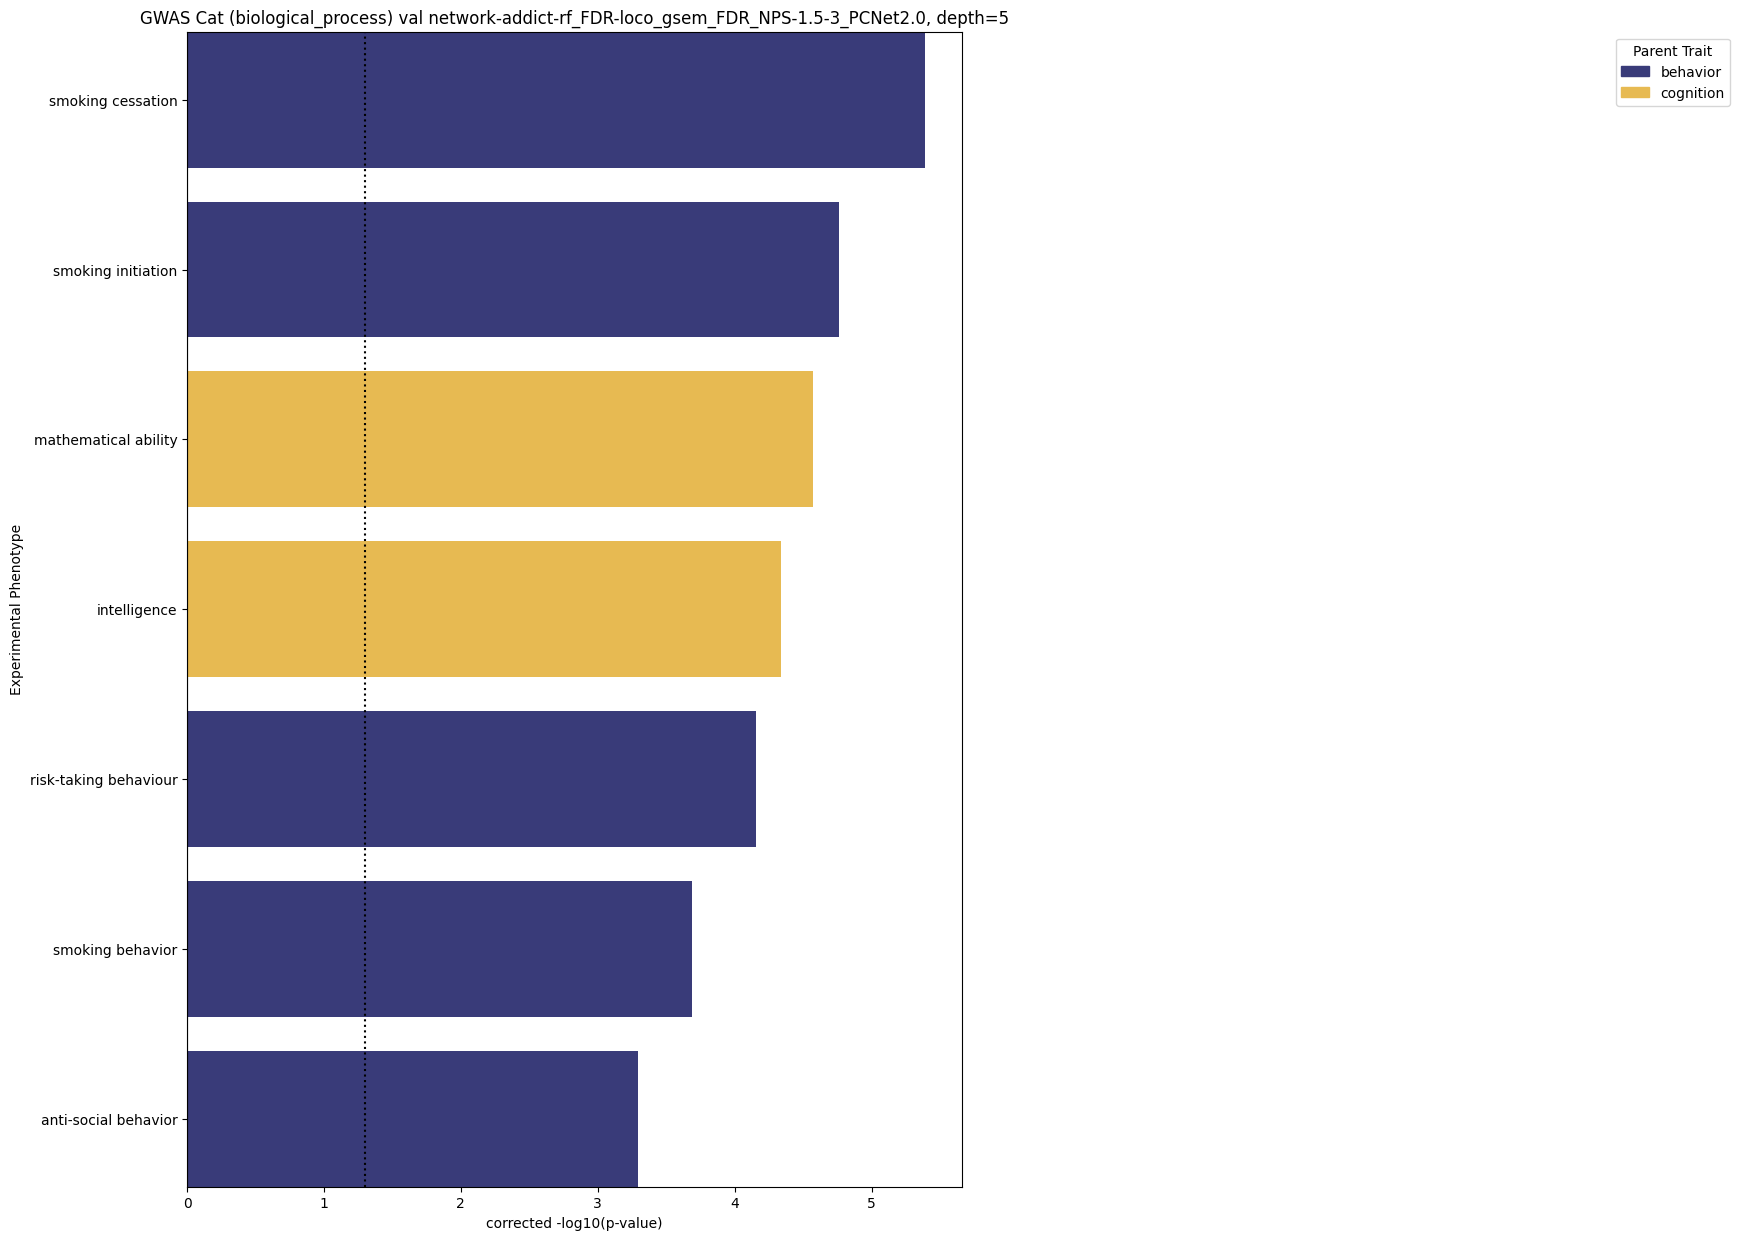

<Figure size 640x480 with 0 Axes>

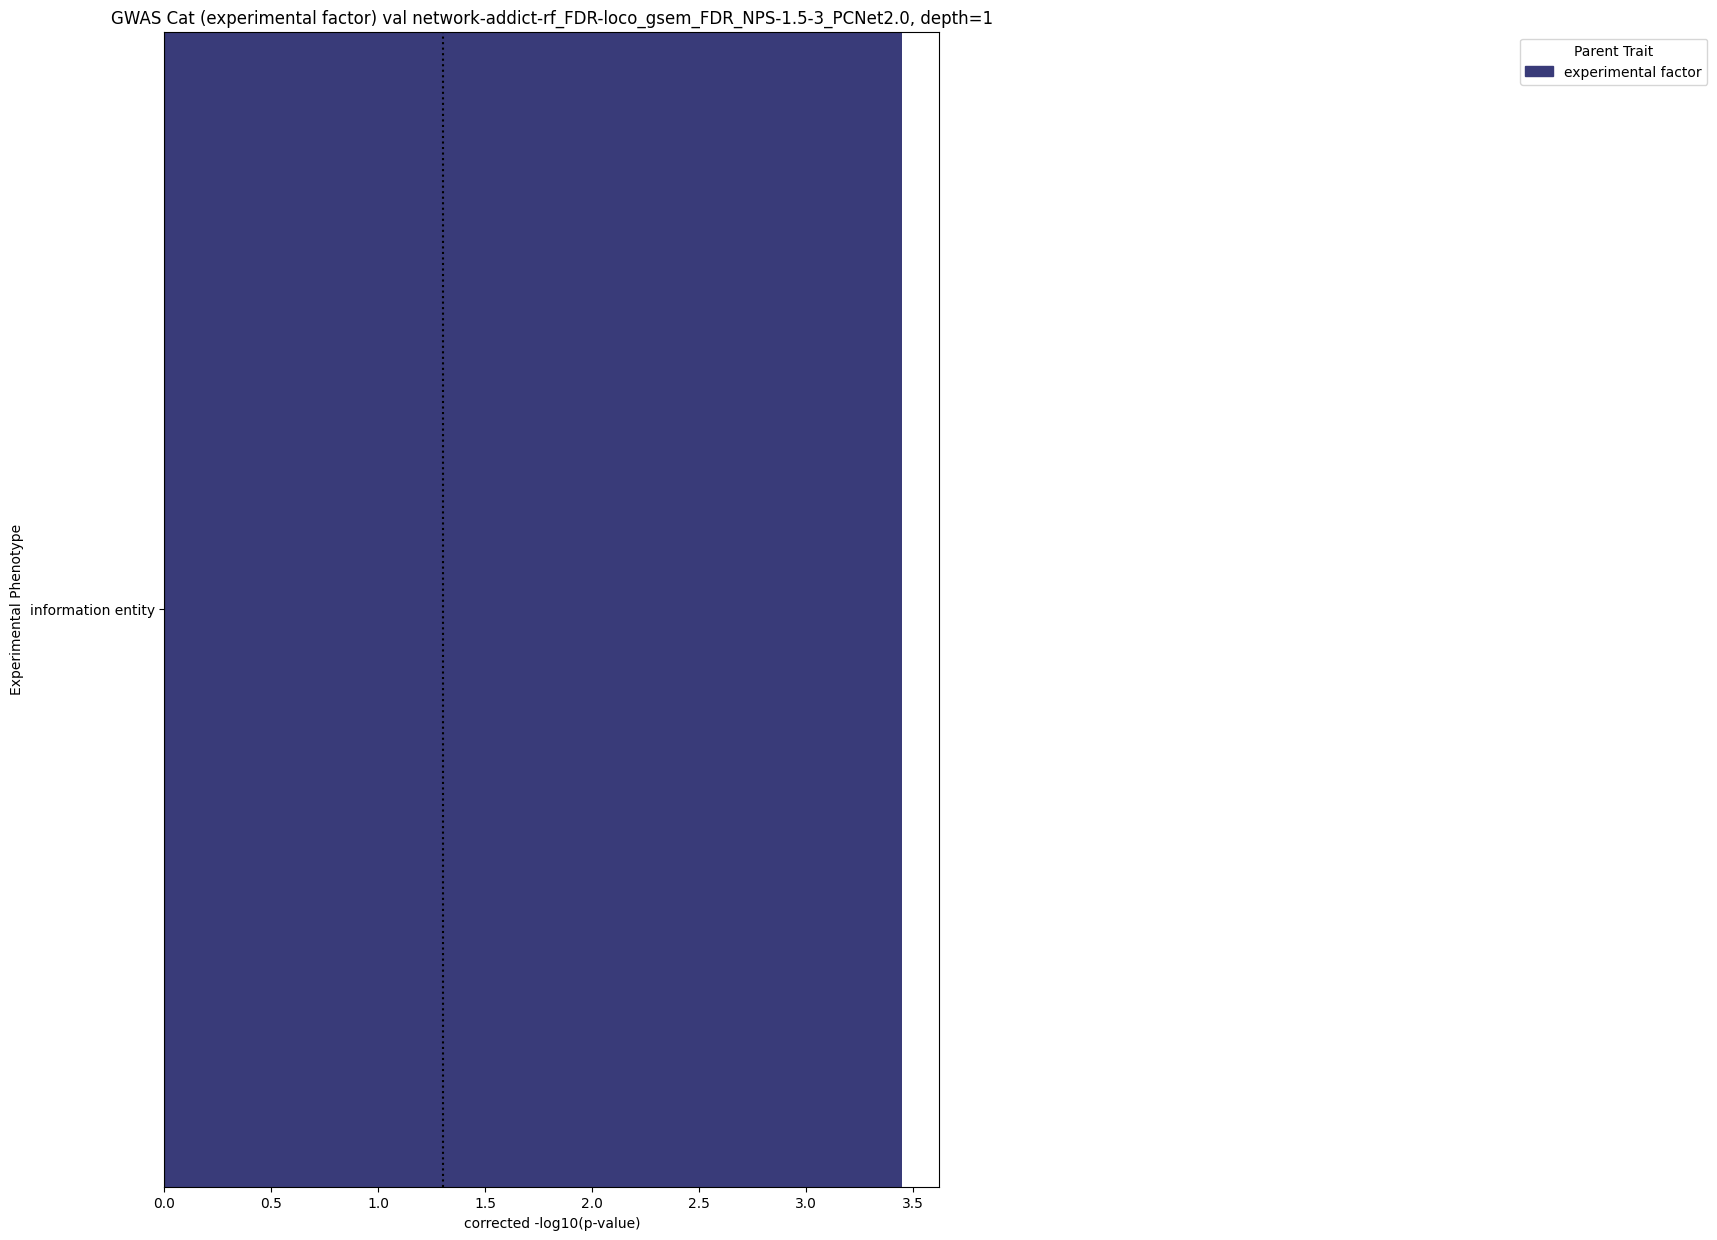

<Figure size 640x480 with 0 Axes>

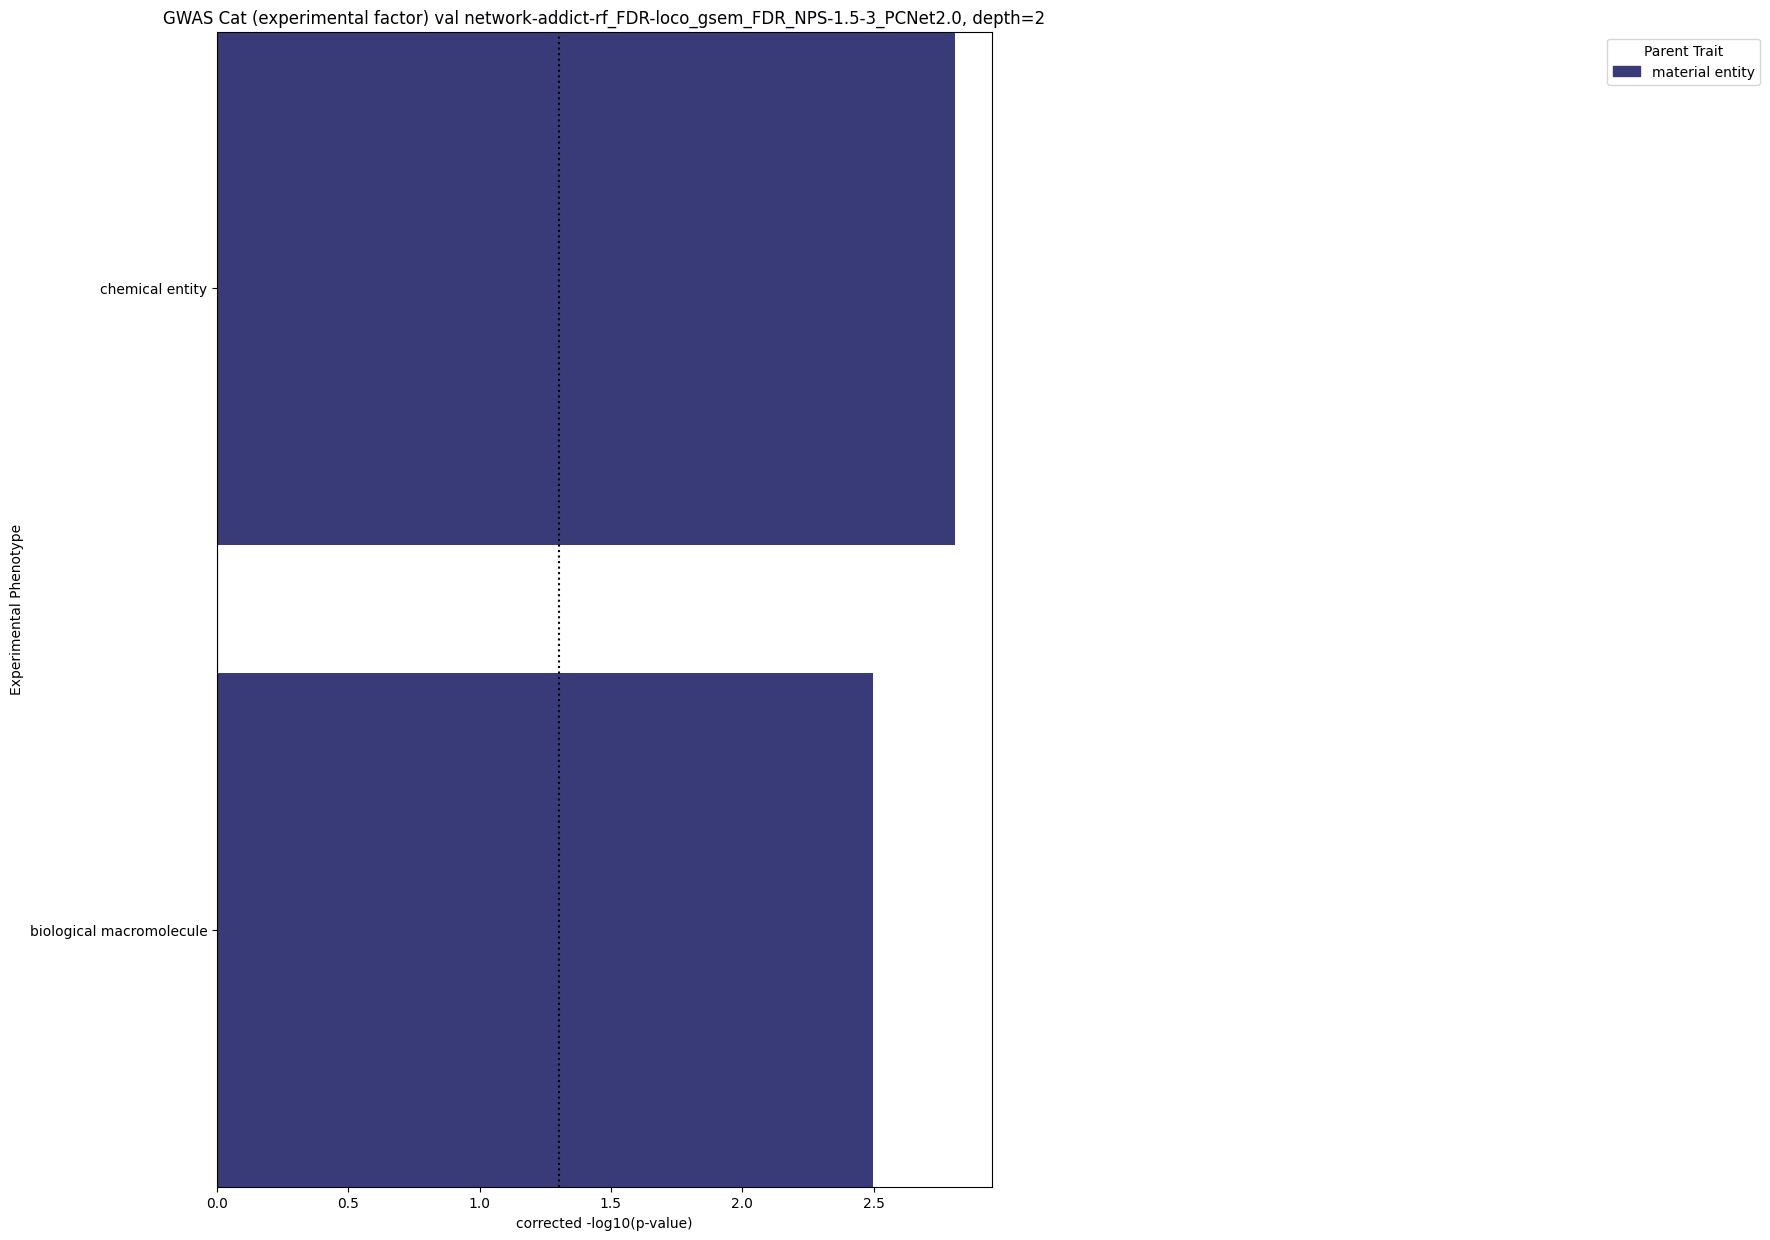

<Figure size 640x480 with 0 Axes>

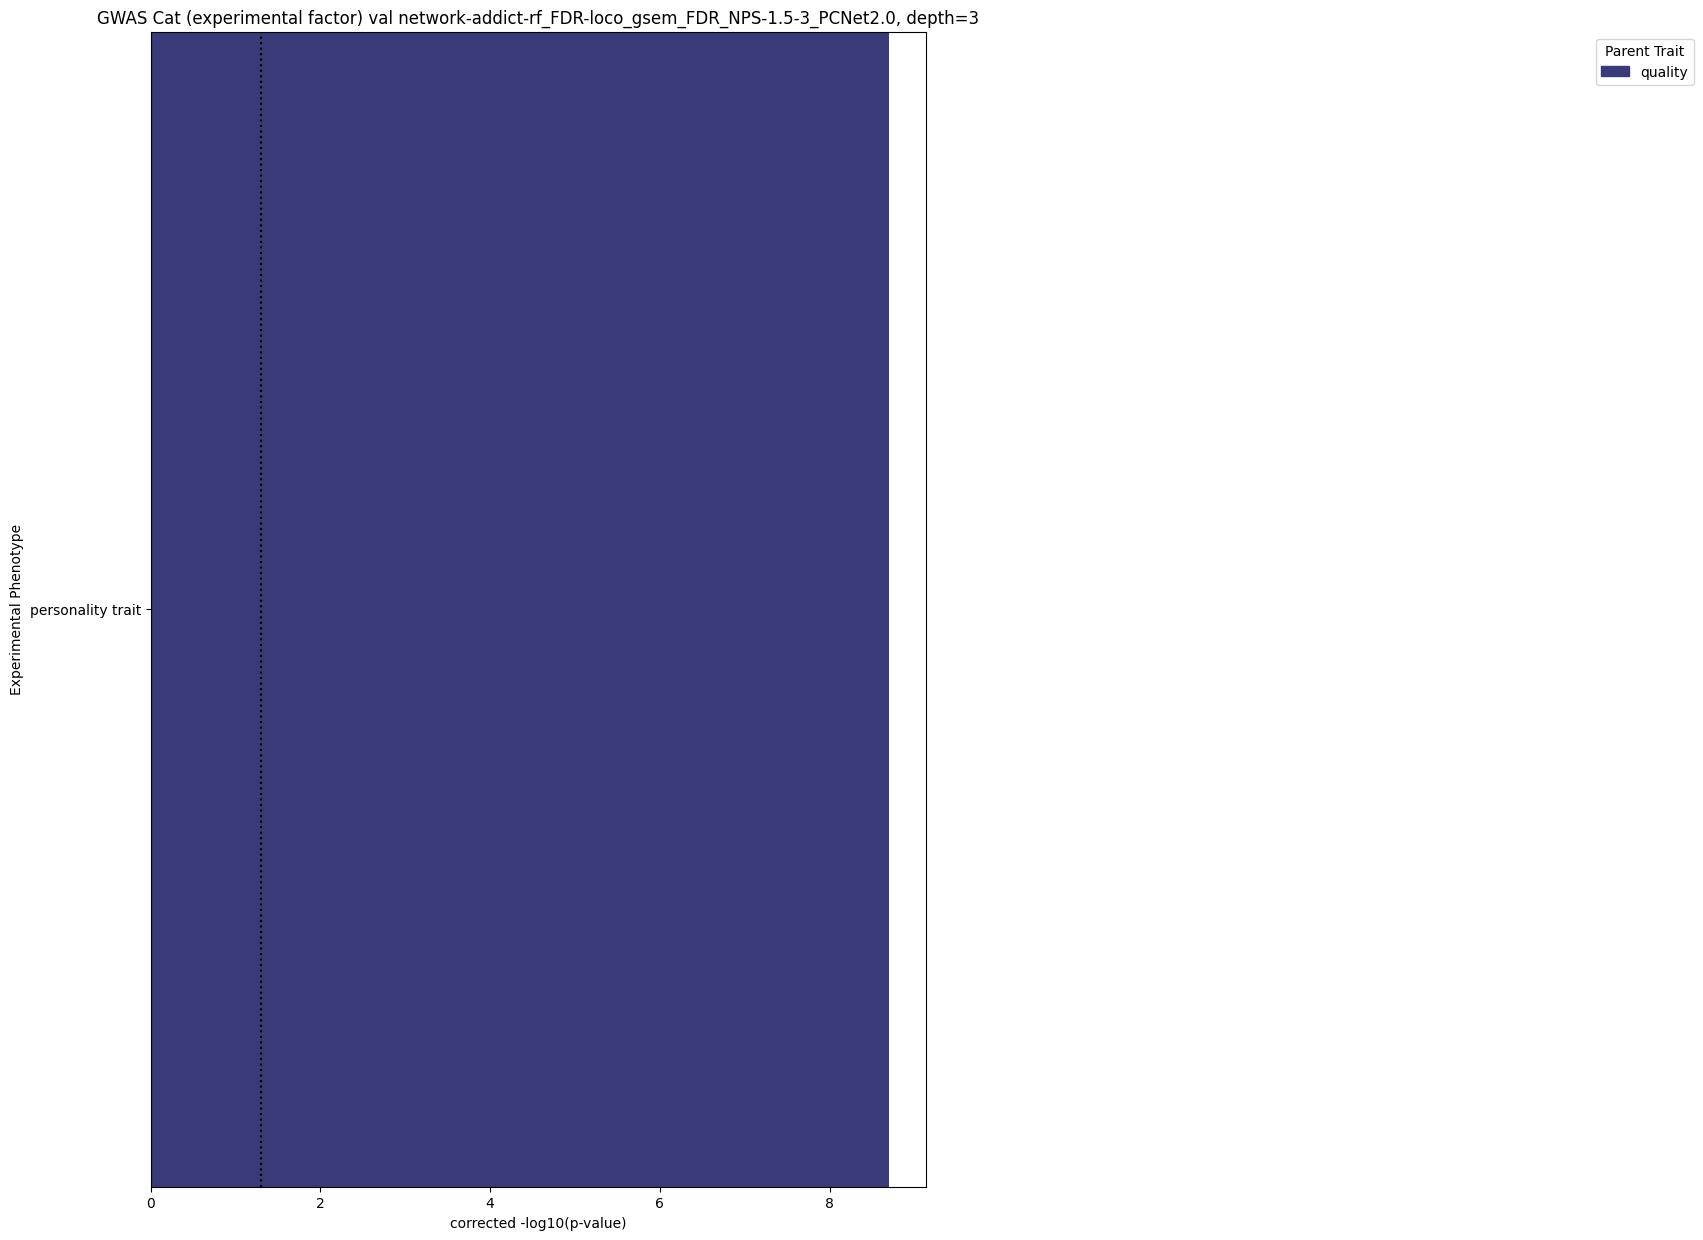

<Figure size 640x480 with 0 Axes>

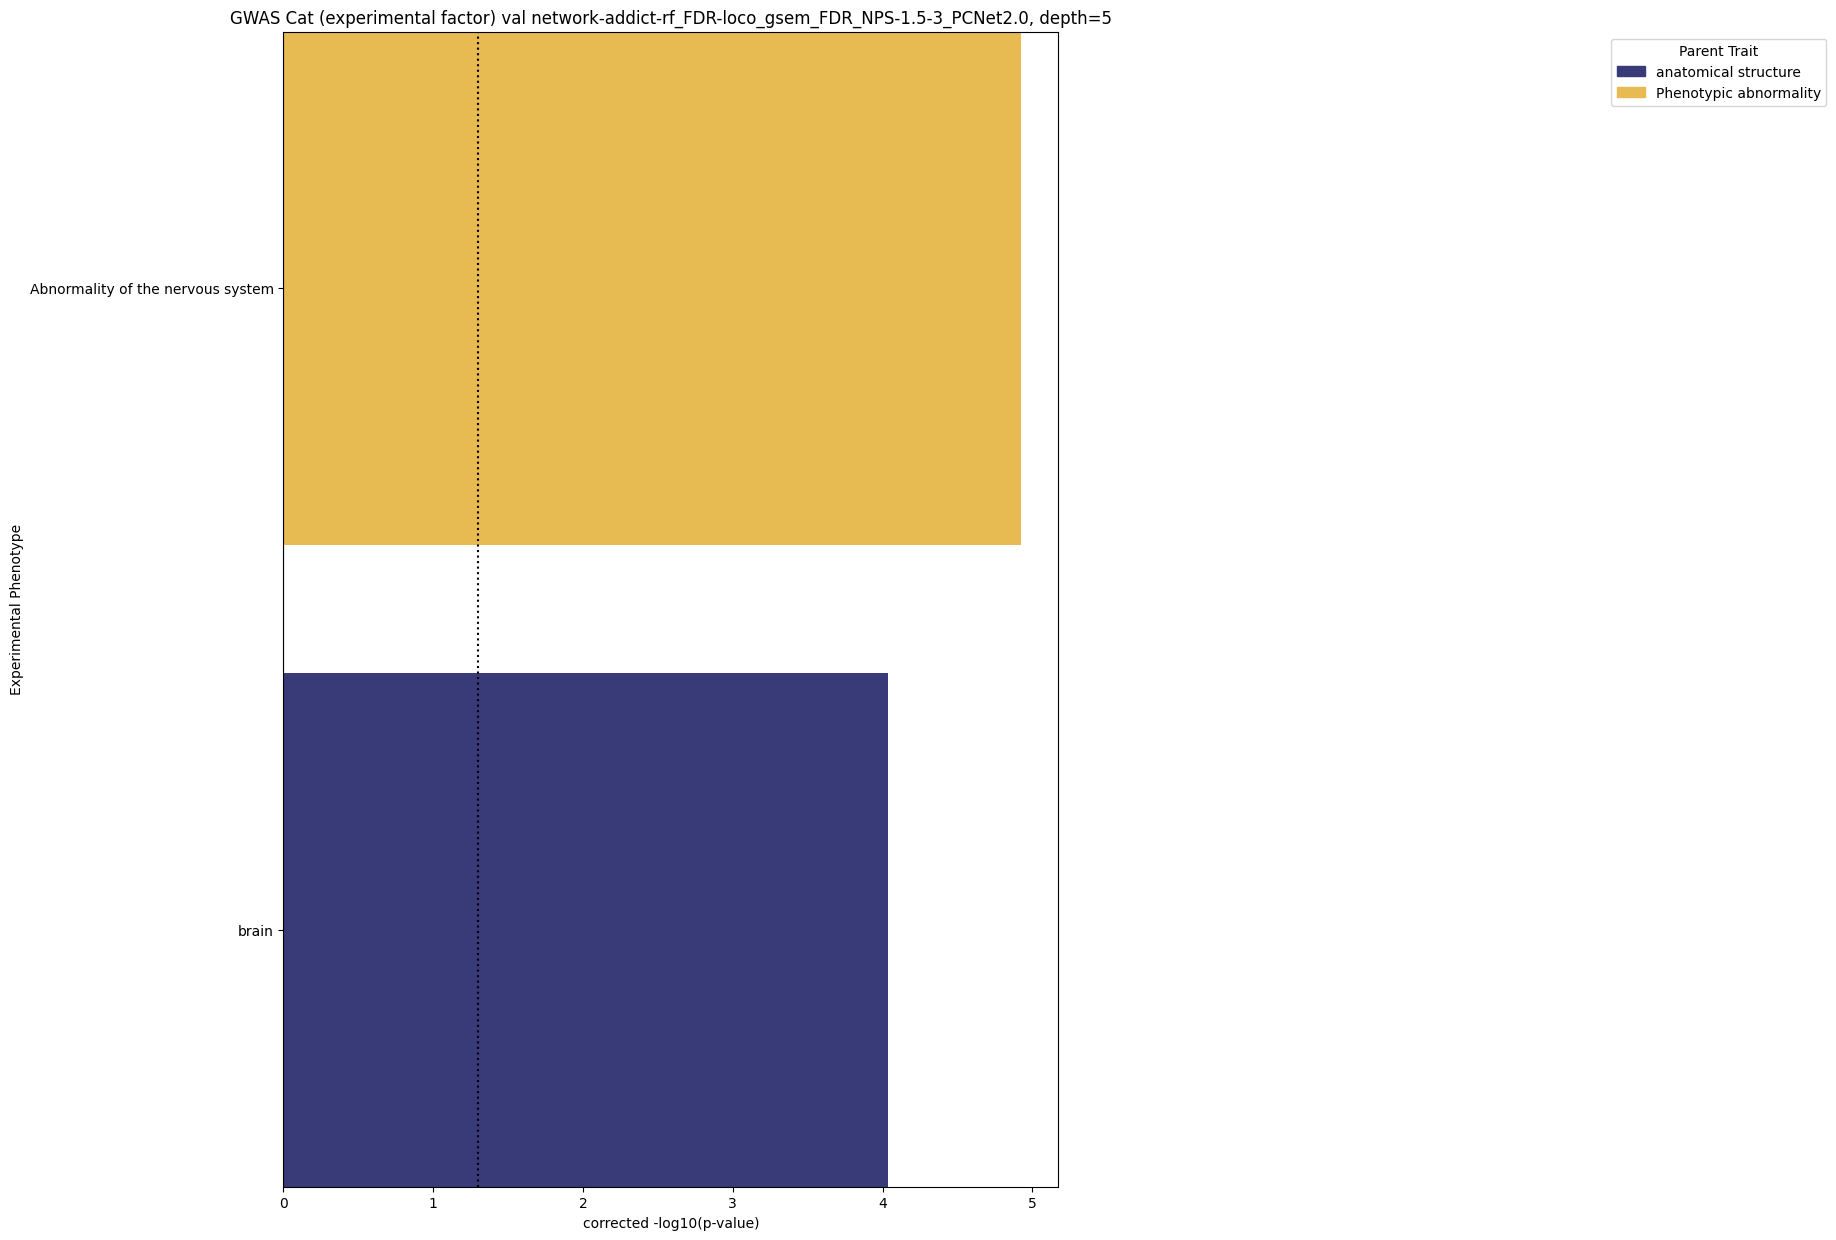

<Figure size 640x480 with 0 Axes>

In [55]:
for p in par:
    children=return_descendents_name(graph,id_to_name, name_to_id[p])
    #make the terms somewhat mutually exclusive- otherwise this is unintelligible
    if p=='disease':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        children=set(children).difference(meas_child)
    if p=='biological_process':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        disease_child=return_descendents_name(graph,id_to_name, name_to_id['disease'])
        children=set(children).difference(meas_child+disease_child)
    if p=='experimental factor':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        disease_child=return_descendents_name(graph,id_to_name, name_to_id['disease'])
        bp_child=return_descendents_name(graph,id_to_name, name_to_id['biological_process'])
        children=set(children).difference(meas_child+disease_child+bp_child)
    tb=tbl[tbl.trait.isin(children)]
    depth_set=set(tb['depth'])
    for d in set(tb['depth']):
        t=tb[tb.depth==d]
        t=t[t['p_intersect']<0.05/len(t)]
        if len(t)>0:
            t=t.sort_values('p_intersect',ascending=False)
            # Assign a unique color for each parent_trait based on its index
            unique_traits = t.parent_trait.unique()
            color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
            
            # Plotting
            fig = plt.figure(figsize=(10, 15))
            colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait
            
            plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(t)),label=t.parent_trait, color=colors)
            
            plt.ylabel('Experimental Phenotype')
            plt.xlabel('corrected -log10(p-value)')
            plt.axvline(-np.log10(0.05), color='black', ls=':')
            plt.axvline(0, color='black', ls='-')
        
            #plt.xticks(rotation=90)
            #plt.title(d)
            plt.title(f'GWAS Cat ({p}) val {val_lab_dict[sub_community]}, depth={d}')
            # Create legend patches (only one for each unique parent_trait)
            legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
            
            # Add legend to the plot
            plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
            #plt.tight_layout()
            plt.margins(y=0)
            # Show the plot
            if save_fig:
                if not filter_traits:
                    plt.savefig((f'{outpath_dir}/GWAS_Cat_{p}_val_bar_depth-{d}.svg'), bbox_inches = "tight")
                else:
                    plt.savefig((f'{outpath_dir}/GWAS_Cat_{p}_val_filtered_bar_depth-{d}.svg'), bbox_inches = "tight")

            plt.show()
            
            # Clear the figure after showing
            plt.clf()